# Machine Learning for Level Truncation in Open String Field Theory

Referencing the [full analysis](sft_level_trunc_full.ipynb) we performed as first step, we now take into consideration only part of the dataset, including in the analysis only those values with a good distribution.

In [1]:
import os

# Jupyter magics
%load_ext autoreload
%autoreload 2

# print machine specs
print('Machine specifications:\n')
!echo "CPU: $(lscpu| awk '/^Model name/ {$1=""; $2=""; print}'| sed 's/^[[:space:]]*//g')"
!echo "GPU: $(lspci| awk '/3D controller/ {$1=""; $2=""; $3=""; print}'| sed 's/^[[:space:]]*//g')"
!echo "RAM: $(free --giga| awk '/^Mem/ {print $2}')GB (avail. now: $(free --giga| awk '/^Mem/ {print $7}')GB)"

# define the no. of threads
THREADS = 4 #-------------------------------------------------------------------- no. of desired threads
MAX_THREADS = os.cpu_count() #--------------------------------------------------- max no. of threads

if THREADS > MAX_THREADS: #------------------------------------------------------ sanity check
    THREADS = MAX_THREADS
    print('Cannot use more than {:d} threads!'.format(MAX_THREADS))

print('Using {:d} of {:d} threads available.'.format(THREADS, MAX_THREADS)) #---- print setup

Machine specifications:

CPU: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
GPU: NVIDIA Corporation GM108M [GeForce 940MX] (rev a2)
RAM: 16GB (avail. now: 8GB)
Using 4 of 8 threads available.


Import main modules and set random seed:

In [2]:
import sys

import numpy             as np
import pandas            as pd
import matplotlib        as mpl
import matplotlib.pyplot as plt
import seaborn           as sns
import sklearn           as skl
import skopt             as skp
import tensorflow        as tf
import xgboost           as xgb

import warnings
warnings.simplefilter('ignore', category = UserWarning) #------ differently from ConvergenceWarning, I can hardly do anything about them...

# set aestetichs parameters
PLT_WIDTH  = 6 #----------------------------------------------- width of a single plot
PLT_HEIGHT = 5 #----------------------------------------------- height of a single plot
pd.set_option('display.max_rows', 50) #------------------------ set a max no. of rows to display in pandas dataframes before truncation
pd.set_option('display.max_columns', 25) #--------------------- set a max no. of columns to display in pandas dataframes before truncation
sns.set()
    
# fix the random seed
RAND = 154
np.random.seed(RAND)
tf.random.set_seed(RAND)

# set memory growth for the GPUs:
gpus = tf.config.experimental.list_physical_devices('GPU') #--------------- get the list of gpus
if gpus: #----------------------------------------------------------------- if there are GPU devices
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) #---------- set memory growth for all of them
    except RuntimeError as e:
        print(e)

Create or load the directory structure:

In [3]:
from os import path, makedirs

# define directory names
ROOT_DIR = '.' #-------------------------------------------------- root directory
IMG_DIR  = 'img' #------------------------------------------------ images
MOD_DIR  = 'mod' #------------------------------------------------ saved models
LOG_DIR  = 'log' #------------------------------------------------ logs
DAT_DIR  = 'dat' #------------------------------------------------ data
OUT_DIR  = 'out' #------------------------------------------------ generic output

DB_NAME = 'sft-data_analysis_full' #------------------------------ name of the dataset
DB_FILE = DB_NAME + '.csv' #-------------------------------------- full name with extension
DB_PATH = path.join(ROOT_DIR, DAT_DIR, DB_FILE) #----------------- full path of the dataset

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR)
DAT_PATH = path.join(ROOT_DIR, DAT_DIR)
OUT_PATH = path.join(ROOT_DIR, OUT_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)
if not path.isdir(DAT_PATH):
    makedirs(DAT_PATH, exist_ok=True)
if not path.isdir(OUT_PATH):
    makedirs(OUT_PATH, exist_ok=True)

For future reports, we also save everything to an external log file:

In [4]:
import logging

from os   import path, rename
from time import strftime, gmtime

logname  = DB_NAME #------------------------------------------------------------- name of the logging session
filename = path.join(LOG_PATH, DB_NAME + '_low.log') #--------------------------- name of the log file
ctime    = strftime('_%Y%m%d.%H%M%S', gmtime()) #-------------------------------- current time
level    = logging.DEBUG #------------------------------------------------------- logging level
    
if path.isfile(filename): #------------------------------------------------------ rotate old log if already present
    print('Rotating existing logs...')
    rename(filename, filename + ctime)

log = logging.getLogger(logname + ctime) #--------------------------------------- create log session
fmt = logging.Formatter('%(asctime)s: %(levelname)s ==> %(message)s') #---------- format of the log ('time: level ==> message')
han = logging.FileHandler(filename = filename) #--------------------------------- set output to file

log.setLevel(level) #------------------------------------------------------------ set internal logging level (e.g. logging.DEBUG, logging.INFO, etc.)
han.setLevel(level) #------------------------------------------------------------ set output logging level
han.setFormatter(fmt) #---------------------------------------------------------- set output format

log.addHandler(han) #------------------------------------------------------------ set output to file

# write introduction to log
log.info('\n\n'
         '--------------------------------------------\n'
         '  MACHINE LEARNING FOR LEVEL TRUNCATION IN\n'
         '  BOSONIC OPEN STRING FIELD THEORY\n\n'
         '--------------------------------------------\n'
         '  Authors: Harold Erbin, Riccardo Finotello\n'
         '--------------------------------------------\n'
         '  Abstract:\n\n'
         '  We consider the position of the lumps of\n'
         '  the tachyon potential in bosonic open\n'
         '  string field theory at a finite mass level\n'
         '  truncation. We then extrapolate the\n'
         '  predictions for level-$\infty$ using\n'
         '  machine learning techniques.\n\n'
        )

Rotating existing logs...


# Visualisation and Manipulation of the Data

We then load the dataframe and apply transformations to the data in order to limit the variability of the data:

In [5]:
df = None
if path.isfile(DB_PATH): #--------------------------------- read the database from JSON
    df = pd.read_csv(DB_PATH)
    
if df is None:
    log.error('Cannot load database from CSV file!') #----- error handling
else:
    log.debug('Database correctly imported.')

Just to check, we display the info related to the dataframe:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   system  718 non-null    int64  
 1   init    718 non-null    float64
 2   weight  718 non-null    float64
 3   type    718 non-null    int64  
 4   2       718 non-null    float64
 5   3       718 non-null    float64
 6   4       718 non-null    float64
 7   5       718 non-null    float64
 8   6       718 non-null    float64
 9   7       718 non-null    float64
 10  8       718 non-null    float64
 11  9       718 non-null    float64
 12  10      718 non-null    float64
 13  11      718 non-null    float64
 14  12      718 non-null    float64
 15  13      718 non-null    float64
 16  14      718 non-null    float64
 17  15      718 non-null    float64
 18  16      718 non-null    float64
 19  17      718 non-null    float64
 20  18      718 non-null    float64
 21  exp     718 non-null    int64  
dtypes:

And their description:

In [7]:
df.describe()

,system,init,weight,type,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,exp
count,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,7.180000e+02,718.000000
mean,24.314763,0.836629,1.981686,3.749304,-1.649589,-1.817170,7.981259,8.445939,-34.541055,-36.169106,172.934603,179.479758,-752.288433,-776.523313,3061.210057,3147.716636,-11562.460857,-11855.258680,40629.386999,41566.669584,-1.334843e+05,0.541783
std,13.023788,1.004161,2.337013,0.662688,4.548304,5.005473,21.558408,22.815235,111.039170,116.338079,613.372450,636.418293,2852.135166,2942.302665,11912.541567,12240.685674,45391.801105,46512.063723,160087.941813,163698.216993,5.278422e+05,0.706857
min,1.000000,0.000000,0.000000,2.000000,-19.744040,-21.893983,-0.754568,-0.782633,-514.984097,-538.627792,-0.909456,-1.781985,-13321.170445,-13781.246472,-8.850113,-12.265769,-211473.396816,-216475.644423,-44.356923,-66.596211,-2.489024e+06,-1.000000
25%,13.000000,0.000000,0.155340,4.000000,-0.819357,-1.048764,0.000000,0.000000,-0.924887,-0.941950,0.000000,0.000000,-1.122517,-2.123912,0.001518,0.001679,-3.214377,-6.185564,0.045728,0.042314,-2.569285e+01,0.000000
50%,25.000000,0.000000,1.000100,4.000000,0.000000,0.000000,0.923914,0.935052,0.000000,0.000000,0.974117,0.975401,0.001407,0.001712,0.987326,0.987066,0.001634,0.004821,1.004445,1.001084,9.732395e-02,1.000000
75%,36.000000,1.650000,3.213367,4.000000,0.795133,0.913984,1.408763,1.552803,0.960644,0.984305,2.341926,2.626999,0.991467,0.996329,4.397037,6.811820,0.997875,1.001248,16.098058,16.131990,1.003658e+00,1.000000
max,45.000000,3.000000,9.000000,4.000000,1.239384,1.358098,122.931347,131.675490,2.275741,2.712998,2823.630938,2890.129013,5.243298,6.283092,56115.100219,57592.698860,16.106978,23.077325,731718.332090,748286.961169,1.033588e+02,1.000000


We then define a cut in the `weight` variable in order to keep only "well behaving" data inside the dataset. In particular we keep `weight` < 1.5:

In [8]:
df_new = df.loc[df['weight'] < 1.5]

The newly transformed dataset has new statistics:

In [9]:
df_new.describe()

,system,init,weight,type,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,exp
count,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000
mean,24.340633,0.781887,0.449350,3.562044,0.336533,0.382607,0.644743,0.693710,0.579849,0.519161,0.553847,0.607899,0.604505,0.560865,0.549947,0.586764,0.603423,0.573210,0.553713,0.579689,0.599676,0.569343
std,12.967719,0.987593,0.470090,0.828116,0.732040,0.827498,0.660929,0.679281,0.827947,0.810916,0.679598,0.700991,0.793631,0.776846,0.660095,0.679236,0.756308,0.743344,0.650708,0.665627,0.731270,0.682130
min,1.000000,0.000000,0.000000,2.000000,-2.305894,-2.665154,-0.754568,-0.782633,-2.178828,-2.312592,-0.909456,-0.913273,-1.796111,-1.859238,-0.946296,-0.946943,-1.426523,-1.473133,-0.962387,-0.962334,-1.204812,-1.000000
25%,13.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.007884,0.009219,0.005147,0.004355,0.003586,0.003585,0.002473,0.002366,0.032482,0.032287,0.001552,0.001499,0.030085,0.029846,0.001091,0.000000
50%,25.000000,0.000000,0.258546,4.000000,0.070025,0.888613,0.924529,0.935573,0.939629,0.955924,0.962956,0.964997,0.963408,0.970480,0.976190,0.976336,0.974067,0.977912,0.981615,0.981992,0.980331,1.000000
75%,35.500000,1.600000,0.998902,4.000000,1.000538,1.060318,1.044229,1.033921,1.017133,1.018657,1.015490,1.013922,1.008896,1.009112,1.008920,1.008619,1.006511,1.006108,1.005960,1.005938,1.004916,1.000000
max,45.000000,3.000000,1.499375,4.000000,1.239384,1.358098,2.349378,2.502320,2.275741,2.346414,2.059841,2.151000,2.511027,2.577205,1.634212,1.681084,2.354431,2.394766,1.292995,1.394159,2.156922,1.000000


We can use the same approach we used before in detecting outlying samples using the _interquartile_ and _interdecile_ ranges:

In [10]:
def iqr_detection(df, feature):
    '''
    Compute the interquartile range of a given feature and return the indices of the outliers.
    
    Required arguments:
        df:      the dataframe to analyse,
        feature: the name of the column to analyse.
        
    Returns:
        the dataframe with the outliers.
    '''
    
    q1, q3 = np.percentile(df[feature], [25, 75]) #---------------------------- get values of 1st and 3rd quartile
    iqr    = q3 - q1 #--------------------------------------------------------- compute the interquartile range (IQR)
    
    lower  = q1 - (iqr * 1.5) #------------------------------------------------ lower bound
    upper  = q3 + (iqr * 1.5) #------------------------------------------------ higher bound
    
    return df.loc[(df[feature] > upper) | (df[feature] < lower)] #------------- return dataframe with indices out of bounds

def idr_detection(df, feature):
    '''
    Compute the interdecile range and return indices of points outside the limit.
    
    Required arguments:
        df:      the dataframe to analyse,
        feature: the name of the column to analyse.
        
    Returns:
        the dataframe with the outliers.
    '''
    
    d1, d9 = np.percentile(df[feature], [10, 90]) #---------------------------- get values of 1st and 9th decile
    idr    = d9 - d1 #--------------------------------------------------------- compute the interdecile range (IDR)

    lower  = d1 - (idr * 1.5) #------------------------------------------------ lower bound
    upper  = d9 + (idr * 1.5) #------------------------------------------------ higher bound
    
    return df.loc[(df[feature] > upper) | (df[feature] < lower)] #------------- return indice out of bounds

# print the outliers
for feature in df_new.columns:
    n_outliers         = iqr_detection(df_new, feature).shape[0]
    n_extreme_outliers = idr_detection(df_new, feature).shape[0]
    
    if n_outliers > 0 or n_extreme_outliers > 0:
        log.info('(outliers|extreme_outliers) in {}: ({:d}|{:d}).'.format(feature, n_outliers, n_extreme_outliers))
    
    print('Number of outlying samples in "{}":         {:d}'.format(feature, n_outliers))
    print('Number of extreme outlying samples in "{}": {:d}'.format(feature, n_extreme_outliers))
    print('\n')

Number of outlying samples in "system":         0
Number of extreme outlying samples in "system": 0


Number of outlying samples in "init":         0
Number of extreme outlying samples in "init": 0


Number of outlying samples in "weight":         0
Number of extreme outlying samples in "weight": 0


Number of outlying samples in "type":         90
Number of extreme outlying samples in "type": 0


Number of outlying samples in "2":         5
Number of extreme outlying samples in "2": 0


Number of outlying samples in "3":         7
Number of extreme outlying samples in "3": 0


Number of outlying samples in "4":         0
Number of extreme outlying samples in "4": 0


Number of outlying samples in "5":         0
Number of extreme outlying samples in "5": 0


Number of outlying samples in "6":         5
Number of extreme outlying samples in "6": 0


Number of outlying samples in "7":         5
Number of extreme outlying samples in "7": 0


Number of outlying samples in "8":         0
Nu

Even though the distribution of the outliers did not change much with respect to the previous case, we can hope to have better distributions of the values with respect to before:

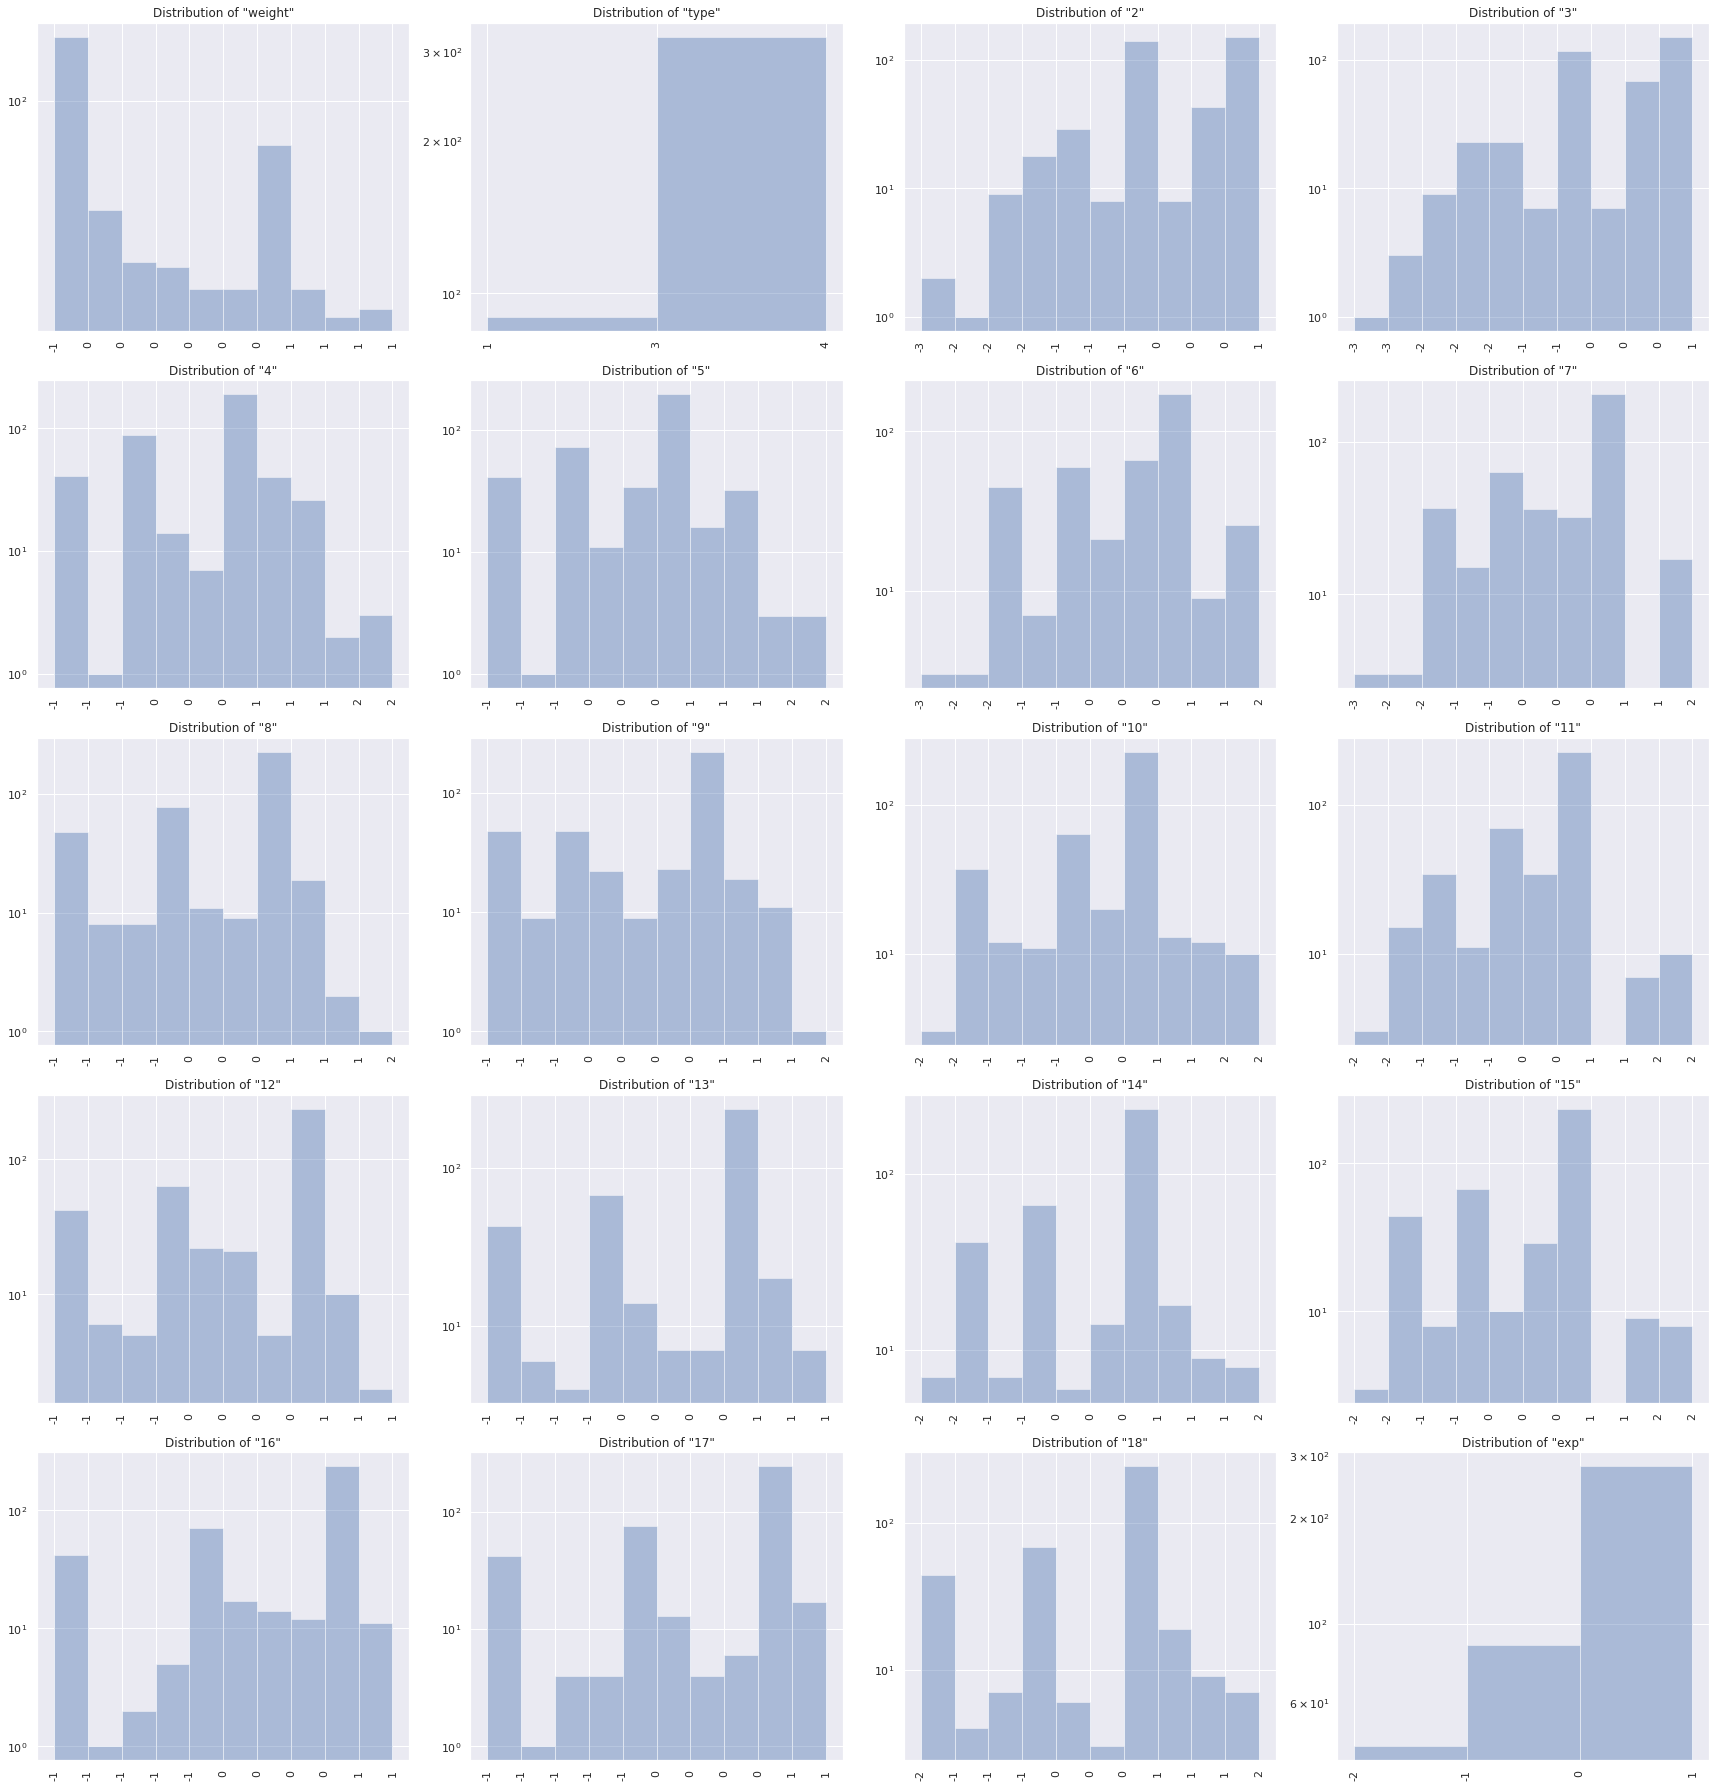

In [11]:
# define a version of the dataframe with only useful column for the plot
df_feature_plot = df_new.drop(columns = ['init', 'system'])

# define a function to draw one single plot given a feature column and the no. of bins
def digitize_plot(feature, n_bins, ax):
    '''
    Digitize the given feature into a certain amount of bins.
    
    Required arguments:
        feature: the feature to digitize,
        n_bins:  the no. of bins,
        ax:      the ax of the subplot.
    '''
    # check how many unique values are in the column
    n_unique = pd.unique(feature).shape[0]
    if n_unique < n_bins:
        n_bins = n_unique #--------------------------------------- n_bins should not be greater than the no. of unique values
        
    # labels and bins
    labels, bins = pd.cut(feature, #------------------------------ the column to digitize
                          bins    = n_bins, #--------------------- the no. of bins to create
                          labels  = range(n_bins), #-------------- call the labels sequentially
                          retbins = True #------------------------ return also the bins
                         )
    
    # plot the histogram
    sns.distplot(labels, bins = range(n_bins + 1), kde = False, axlabel = False, ax = ax)
    ax.set_title('Distribution of "{}"'.format(feature.name))
    ax.set_xticks(range(n_bins + 1))
    ax.set_xticklabels(np.floor(bins).astype(int), rotation = 90)
    ax.set_yscale('log')
    
# now draw a grid of histograms
ncols = 4
nrows = 5

# choose the number of bins
n_bins = 10

# take the names of the feature sand distribute them in the grid
features = np.array(df_feature_plot.columns).reshape(nrows, ncols)

# create the plot
distr_feature_fig, distr_feature_plot = plt.subplots(ncols = ncols, nrows = nrows, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

for i in range(nrows):
    for j in range(ncols):
        digitize_plot(df_feature_plot[features[i,j]], n_bins, distr_feature_plot[i,j])

distr_feature_fig.tight_layout()
distr_feature_fig.savefig(path.join(IMG_PATH, 'distr_feature_low.pdf'), dpi = 300, format = 'pdf')
distr_feature_fig.savefig(path.join(IMG_PATH, 'distr_feature_low.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(distr_feature_fig)

We can also hope that standardising the features may help in recovering good distributions. This can be done after splitting into training and test sets.

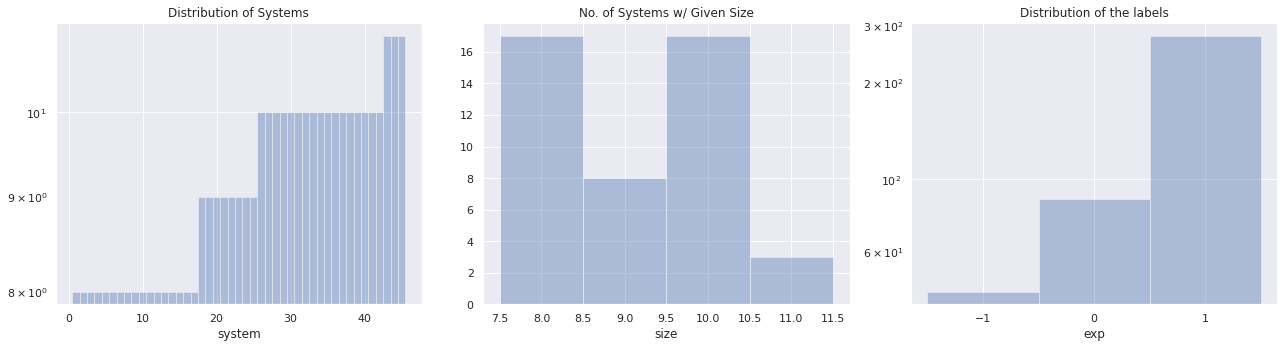

In [12]:
nrows = 1
ncols = 3
system_distr_fig, system_distr_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

system_data = df_new['system']
system_distr_plot[0].set(yscale = 'log', title = 'Distribution of Systems')
sns.distplot(system_data,
             bins     = range(system_data.min(), system_data.max() + 2),
             hist_kws = {'align': 'left'},
             kde      = False,
             axlabel  = 'system',
             ax       = system_distr_plot[0]
            )

size_data = df_new.groupby(by='system').count().max(axis = 1)
system_distr_plot[1].set(title = 'No. of Systems w/ Given Size')
sns.distplot(size_data,
             bins     = range(size_data.min(), size_data.max() + 2),
             hist_kws = {'align': 'left'},
             kde      = False,
             axlabel  = 'size',
             ax       = system_distr_plot[1]
            )

labels_data = df_new['exp']
system_distr_plot[2].set(yscale = 'log', title = 'Distribution of the labels', xticks = range(labels_data.min(), labels_data.max() + 1))
sns.distplot(labels_data,
             bins     = range(labels_data.min(), labels_data.max() + 2),
             hist_kws = {'align': 'left'},
             kde      = False,
             axlabel  = 'exp',
             ax       = system_distr_plot[2]
            )

system_distr_fig.tight_layout()
system_distr_fig.savefig(path.join(IMG_PATH, 'system_distr_low.pdf'), dpi = 300, format = 'pdf')
system_distr_fig.savefig(path.join(IMG_PATH, 'system_distr_low.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(system_distr_fig)

We finally visualise the correlation matrix:

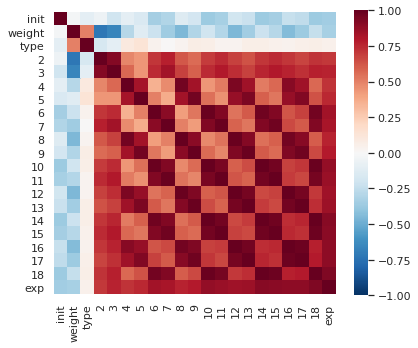

In [13]:
corr_mat_fig, corr_mat_plot = plt.subplots(figsize = (PLT_WIDTH, PLT_HEIGHT))

corr_mat_plot = sns.heatmap(df_new.iloc[:,1:].corr(), #------------------------------ avoid taking the 'system' column
                            ax     = corr_mat_plot,
                            vmin   = -1.0,
                            vmax   = 1.0,
                            square = True,
                            cbar   = True,
                            cmap   = 'RdBu_r',
                            center = 0.0
                           )

corr_mat_fig.tight_layout()
corr_mat_fig.savefig(path.join(IMG_PATH, 'corr_mat_low.pdf'), dpi = 300, format = 'pdf')
corr_mat_fig.savefig(path.join(IMG_PATH, 'corr_mat_low.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(corr_mat_fig)

We finally save the dataset for further use:

In [14]:
df_new = df_new[['system', 'init', 'weight', 'type', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', 'exp']]
df_new = df_new.loc[df_new['system'] != 0] #--------------------- drop the first system
df_new = df_new.reset_index(drop = True) #----------------------- reset the index

fp = path.join(DAT_PATH, 'sft-data_analysis_low.csv') #---------- choose the filepath
df_new.to_csv(fp, index = False) #------------------------------- save the dataset

log.debug('Dataset saved to CSV file.')

# Analysis

We then move to the analysis in which we consider decision tree based algorithms to predict the value of the extrapolations.

## Test and Validation Sets

We use the same splits as before, thus considering 20% of the systems in the test set, and then split the remaining training set into 40% for validation and 60% for training.

In [15]:
from sklearn.model_selection import train_test_split

# select unique systems
systems = df_new['system'].unique()

# split into training and test sets
systems_train, systems_test = train_test_split(systems, test_size=0.2, shuffle=True, random_state=RAND)
systems_train, systems_dev  = train_test_split(systems_train, test_size=0.2, shuffle=True, random_state=RAND)

Then select the train and test validation splits:

In [16]:
df_train = df_new.loc[df_new['system'].isin(systems_train)]
df_dev   = df_new.loc[df_new['system'].isin(systems_dev)]
df_test  = df_new.loc[df_new['system'].isin(systems_test)]

print('Size of the training set: {:d} samples ({:.1f}% of the total set)'.format(df_train.shape[0], 100 * df_train.shape[0] / df_new.shape[0]))
print('Size of the validation set: {:d} samples ({:.1f}% of the total set)'.format(df_dev.shape[0], 100 * df_dev.shape[0] / df_new.shape[0]))
print('Size of the test set: {:d} samples ({:.1f}% of the total set)'.format(df_test.shape[0], 100 * df_test.shape[0] / df_new.shape[0]))

Size of the training set: 260 samples (63.3% of the total set)
Size of the validation set: 74 samples (18.0% of the total set)
Size of the test set: 77 samples (18.7% of the total set)


We then move to the analysis presenting the results of plain linear regression and tree based algorithms.

In [17]:
import re
import numpy as np

from scipy                   import stats
from sklearn.linear_model    import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm             import LinearSVR, SVR
from lightgbm                import LGBMRegressor
from tensorflow              import keras
from sklearn.model_selection import ParameterGrid
from skopt                   import gp_minimize
from skopt.utils             import use_named_args
from sklearn.metrics         import mean_squared_error, \
                                    mean_absolute_error, \
                                    r2_score, \
                                    explained_variance_score

def pretty_print(dictionary):
    '''
    Pretty print a dictionary.
    
    Required argument:
        dictionary: the dictionary.
    '''
    length = max([len(k) for k in dictionary.keys()]) #------------------- get max length
    
    for key, value in dictionary.items():
        key   = key.ljust(length).replace('_', ' ').upper() #------------- pad and replace underscores
        key   = re.sub(r'(TRAIN|DEV|TEST) *$',
                       lambda match: match.group(1).lower() + ' SET', #--- add human readable output
                       key
                      )
        value = value.lower() if isinstance(value, str) else value
        print('{} = {}'.format(key, value))
    print('\n')

def confidence_interval(y_true, y_pred, confidence = 0.95):
    '''
    Compute the confidence interval of the variance.
    
    Required arguments:
        y_true: true values,
        y_pred: predictions.
        
    Returns:
        the array of lower and upper bounds of the confidence interval.
    '''
    
    # compute the deviation of the data and the squared errors
    deviation = y_pred - y_true #-------------------------------------- > 0 if overestimating, < 0 if underestimating
    sq_errors = deviation ** 2 #--------------------------------------- squared errors

    conf_interval = stats.t.interval(confidence,
                                     sq_errors.shape[0] - 1,
                                     loc   = sq_errors.mean(),
                                     scale = stats.sem(sq_errors)
                                    ) #-------------------------------- compute the confidence interval
    
    return conf_interval

class Analysis:
    '''
    Build several algorithms and fit the data onto them.
    
    Public methods:
        linear_regression: linear regression algorithm,
        elastic_net:       elastic net regression algorithm (l1 and l2 regularised linear regression),
        lasso:             lasso regression algorithm (l1 regularised linear regression),
        ridge:             ridge regression algorithm (l2 regularised linear regression),
        linear_svr:        linear SVR algorithm,
        svr_rbf:           SVR algorithm with Gaussian (rbf) kernel,
        random_forest:     random forest of decision trees,
        gradient_boost:    boosted decision trees,
        ann:               artificial fully connected neural network.
        
    Private methods:
        __ann_model:       build the ANN model.
        
    Getters:
        get_train_data:    get training data (x_train, y_train),
        get_dev_data:      get dev data (x_dev, y_dev),
        get_test_data:     get test data (x_test, y_test),
        get_random_state:  get random state,
        get_n_jobs:        get no. of threads.
    
    Setters:
        set_train_data:    set training data,
        set_dev_data:      set dev data,
        set_test_data:     set test data,
        set_random_state:  set random state,
        set_n_jobs:        set no. of threads.
    '''
    
    def __init__(self,
                 train_data,
                 dev_data,
                 test_data,
                 random_state = None,
                 n_jobs = 1):
        '''
        Class constructor.
        
        Required arguments:
            train_data: tuple containing training data (x_train, y_train)
            dev_data:   tuple containing development data (x_dev, y_dev)
            test_data:  tuple containing test data (x_test, y_test)
            
        Optional arguments:
            random_state: the random seed,
            n_jobs:       the number of concurrent threads.
        '''
        # initialize the variables
        self.__x_train, self.__y_train = train_data
        self.__x_dev,   self.__y_dev   = dev_data
        self.__x_test,  self.__y_test  = test_data
        self.__random_state = random_state
        self.__n_jobs       = n_jobs
    
    # define the getters
    def get_train_data(self):
        '''
        Getter method for the training data.
        
        Returns:
            the training data
        '''
        return (self.__x_train, self.__y_train)
    
    def get_dev_data(self):
        '''
        Get method for the development data.
        
        Returns:
            the development data
        '''
        return (self.__x_dev, self.__y_dev)
    
    def get_test_data(self):
        '''
        Get method for the test data.
        
        Returns:
            the test data
        '''
        return (self.__x_test, self.__y_test)
    
    def get_random_state(self):
        '''
        Get method for the random state.
        
        Returns:
            the random state
        '''
        return self.__random_state
    
    def get_n_jobs(self):
        '''
        Get method for the no. of concurrent threads.
        
        Returns:
            the no. of concurrent threads
        '''
        return self.__n_jobs
    
    # define the setters
    def set_train_data(self, train_data):
        '''
        Set method for the training data.
        
        Required arguments:
            train_data: the training data.
        '''
        self.__x_train, self.__y_train = train_data
    
    def set_dev_data(self, dev_data):
        '''
        Set method for the development data.
        
        Required arguments:
            dev_data: the development data.
        '''
        self.__x_dev, self.__y_dev = dev_data
    
    def set_test_data(self, test_data):
        '''
        Set method for the test data.
        
        Required arguments:
            test_data: the test data.
        '''
        self.__x_test, self.__y_test = test_data
    
    def set_random_state(self, random_state):
        '''
        Set method for the random state.
        
        Required arguments:
            random_state: the random seed.
        '''
        self.__random_state = random_state
    
    def set_n_jobs(self, n_jobs):
        '''
        Set method for the no. of concurrent threads.
        
        Required arguments:
            n_jons: the no. of concurrent threads.
        '''
        self.__n_jobs = n_jobs
        
    # build a neural network model
    def __ann_model(self,
                    n_layers            = 1,
                    n_units             = 10,
                    learning_rate       = 0.1,
                    epochs              = 10,
                    activation          = 'relu',
                    slope               = 0.3,
                    dropout             = True,
                    dropout_rate        = 0.2,
                    batch_normalization = True,
                    momentum            = 0.99,
                    l1_reg              = 0.0,
                    l2_reg              = 0.0
                   ):
        '''
        Create and return a compiled Tensorflow model.

        Required parameters:

        Optional parameters:
            n_layers:            the number of fully connected layers to insert,
            n_units:             the number of units in each layer,
            learning_rate:       the learning rate of gradient descent,
            epochs:              the number of epochs for training,
            activation:          the name of the activation function ('relu' for ReLU or else for LeakyReLU)
            slope:               the slope of the LeakyReLU activation (ignored if ReLU),
            dropout:             whether to use dropout,
            dropout_rate:        the dropout rate (ignored if no dropout),
            batch_normalization: whether to use batch normalization,
            momentum:            the momentum of batch normalization,
            l1_reg:              amount of l1 regularisation,
            l2_reg:              amount of l2 regularisation.

        Returns:
            the fitted model and its history.
        '''

        # instantiate the model
        keras.backend.clear_session()
        model = keras.Sequential(name = 'sft_trunc') #--------------------------------------- create the model
        model.add(keras.layers.InputLayer(input_shape = self.__x_train.shape[1:], name='input'))

        # add FC layers
        for n in range(n_layers):
            model.add(keras.layers.Dense(units                = n_units,
                                         kernel_initializer   = keras.initializers.glorot_uniform(seed = self.__random_state),
                                         bias_initializer     = tf.zeros_initializer(),
                                         activity_regularizer = keras.regularizers.l1_l2(l1 = l1_reg, l2 = l2_reg),
                                         name                 = 'dense_{:d}'.format(n)
                                        )
                     ) #--------------------------------------------------------------------- add FC layer
            if activation == 'relu':
                model.add(keras.layers.Activation('relu',
                                                  name = 'activation_{:d}'.format(n)
                                                 )
                         )
            else:
                model.add(keras.layers.LeakyReLU(alpha = slope,
                                                 name  = 'activation_{:d}'.format(n)
                                                )
                         ) #----------------------------------------------------------------- add activation layer
            if batch_normalization:
                model.add(keras.layers.BatchNormalization(momentum = momentum,
                                                          name     = 'batch_norm_{:d}'.format(n)
                                                         )
                         ) #----------------------------------------------------------------- add batch normalization layer
            if dropout:
                model.add(keras.layers.Dropout(rate = dropout_rate,
                                               seed = self.__random_state,
                                               name = 'dropout_{:d}'.format(n)
                                              )
                         ) #----------------------------------------------------------------- add dropout layer

        # add the output layer
        model.add(keras.layers.Dense(units              = 1,
                                     kernel_initializer = keras.initializers.glorot_uniform(seed = self.__random_state),
                                     bias_initializer   = tf.zeros_initializer(),
                                     name               = 'output'
                                    )
                 ) #------------------------------------------------------------------------- add output layer

        # compile the model
        model.compile(keras.optimizers.Adam(learning_rate = learning_rate),
                      loss       = keras.losses.MeanSquaredError(),
                      metrics    = [keras.metrics.MeanSquaredError(), keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsoluteError()]
                     )

        return model
    
    # define the algorithms
    def linear_regression(self, params, optimization = False):
        '''
        Linear regression model.
        
        Required arguments:
            params:       dict of hyperparameters.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (grid search).
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # initialise parameters
            best_model           = None #--------------------------------------------------------- unknown for the moment
            best_hyperparameters = None #------------------------------------------------------------- unknown for the moment
            best_mae_train       = np.inf #------------------------------------------------------- highest possible value
            best_mae_dev         = np.inf #------------------------------------------------------- highest possible value
            best_mae_test        = np.inf #------------------------------------------------------- highest possible value
            best_mse_train       = np.inf #------------------------------------------------------- highest possible value
            best_mse_dev         = np.inf #------------------------------------------------------- highest possible value
            best_mse_test        = np.inf #------------------------------------------------------- highest possible value
            best_r2_train        = -np.inf #------------------------------------------------------ highest possible value
            best_r2_dev          = -np.inf #------------------------------------------------------ highest possible value
            best_r2_test         = -np.inf #------------------------------------------------------ highest possible value
            best_evr_train       = -np.inf #------------------------------------------------------ highest possible value
            best_evr_dev         = -np.inf #------------------------------------------------------ highest possible value
            best_evr_test        = -np.inf #------------------------------------------------------ highest possible value
            best_train_pred      = None #--------------------------------------------------------- unknown for the moment
            best_dev_pred        = None #--------------------------------------------------------- unknown for the moment
            best_test_pred       = None #--------------------------------------------------------- unknown for the moment
            best_cint_train      = None #--------------------------------------------------------- unknown for the moment
            best_cint_dev        = None #--------------------------------------------------------- unknown for the moment
            best_cint_test       = None #--------------------------------------------------------- unknown for the moment
            
            # generate a grid of choices and loop over it
            params_grid = list(ParameterGrid(params)) #------------------------------------------- create a grid of possible choices
            for i in range(len(params_grid)):
                log.debug('Exploring {}'.format(params_grid[i]))
                lin_reg = LinearRegression(n_jobs = self.__n_jobs,
                                           normalize = False,
                                           **params_grid[i]
                                          )
                lin_reg.fit(self.__x_train, self.__y_train.ravel()) #------------------------------ fit the estimator
                
                y_train_pred = lin_reg.predict(self.__x_train).reshape(-1,1) #--------------------- generate training predictions
                y_dev_pred   = lin_reg.predict(self.__x_dev).reshape(-1,1) #----------------------- generate development predictions
                y_test_pred  = lin_reg.predict(self.__x_test).reshape(-1,1) #---------------------- generate test predictions
                
                mae_train  = mean_absolute_error(self.__y_train, y_train_pred) #------------------- compute MAE for training data
                mae_dev    = mean_absolute_error(self.__y_dev, y_dev_pred) #----------------------- compute MAE for validation data
                mae_test   = mean_absolute_error(self.__y_test, y_test_pred) #--------------------- compute MAE for test data
                mse_train  = mean_squared_error(self.__y_train, y_train_pred) #-------------------- compute MSE for training data
                mse_dev    = mean_squared_error(self.__y_dev, y_dev_pred) #------------------------ compute MSE for validation data
                mse_test   = mean_squared_error(self.__y_test, y_test_pred) #---------------------- compute MSE for test data
                r2_train   = r2_score(self.__y_train, y_train_pred) #------------------------------ compute R2 for training data
                r2_dev     = r2_score(self.__y_dev, y_dev_pred) #---------------------------------- compute R2 for validation data
                r2_test    = r2_score(self.__y_test, y_test_pred) #-------------------------------- compute R2 for test data
                evr_train  = explained_variance_score(self.__y_train, y_train_pred) #-------------- compute EVR for training data
                evr_dev    = explained_variance_score(self.__y_dev, y_dev_pred) #------------------ compute EVR for validation data
                evr_test   = explained_variance_score(self.__y_test, y_test_pred) #---------------- compute EVR for test data
                cint_train = confidence_interval(self.__y_train, y_train_pred) #------------------- compute 95% confindence for training data
                cint_dev   = confidence_interval(self.__y_dev, y_dev_pred) #----------------------- compute 95% confindence for validation data
                cint_test  = confidence_interval(self.__y_test, y_test_pred) #--------------------- compute 95% confindence for test data
                
                if mse_dev < best_mse_dev: #------------------------------------------------------- update the best results (only dev set for comparison)
                    best_model           = lin_reg
                    best_hyperparameters = params_grid[i]
                    best_mae_train       = mae_train
                    best_mae_dev         = mae_dev
                    best_mae_test        = mae_test
                    best_mse_train       = mse_train
                    best_mse_dev         = mse_dev
                    best_mse_test        = mse_test
                    best_r2_train        = r2_train
                    best_r2_dev          = r2_dev
                    best_r2_test         = r2_test
                    best_evr_train       = evr_train
                    best_evr_dev         = evr_dev
                    best_evr_test        = evr_test
                    best_train_pred      = y_train_pred
                    best_dev_pred        = y_dev_pred
                    best_test_pred       = y_test_pred
                    best_cint_train      = cint_train
                    best_cint_dev        = cint_dev
                    best_cint_test       = cint_test
            
            # organise the predictions
            best_predictions = {'y_train_pred': best_train_pred,
                                'y_dev_pred':   best_dev_pred,
                                'y_test_pred':  best_test_pred
                               }
            
            # organise the metrics
            best_metrics = {'mae_train': best_mae_train,
                            'mae_dev':   best_mae_dev,
                            'mae_test':  best_mae_test,
                            'mse_train': best_mse_train,
                            'mse_dev':   best_mse_dev,
                            'mse_test':  best_mse_test,
                            'r2_train':  best_r2_train,
                            'r2_dev':    best_r2_dev,
                            'r2_test':   best_r2_test,
                            'evr_train': best_evr_train,
                            'evr_dev':   best_evr_dev,
                            'evr_test':  best_evr_test
                           }
            
            # organise the confidence intervals
            best_cint = {'train': best_cint_train,
                         'dev':   best_cint_dev,
                         'test':  best_cint_test
                        }
            
            return best_model, best_hyperparameters, best_predictions, best_metrics, best_cint
        else:
            # define the estimator and fit
            lin_reg = LinearRegression(n_jobs = self.__n_jobs, normalize = False, **params) #------- define the estimator
            lin_reg.fit(self.__x_train, self.__y_train.ravel()) #----------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = lin_reg.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = lin_reg.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = lin_reg.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred), #------------------- compute 95% confindence for training data
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred), #----------------------- compute 95% confindence for validation data
                    'test':  confidence_interval(self.__y_test, y_test_pred) #---------------------- compute 95% confindence for test data
                   }
            
            return lin_reg, predictions, metrics, cint
        
    def elastic_net(self, params, optimization = False, n_calls = 10, max_iter = 1e3, tol = 1.0e-4):
        '''
        Elastic Net regression model.
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation,
            max_iter:     maximum number of iterations (elastic net),
            tol:          tolerance (elastic net).
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # define the estimator
            el_net = ElasticNet(random_state = self.__random_state,
                                normalize = False,
                                max_iter = max_iter,
                                tol = tol
                               )
            
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # fit the estimator to the train set
                el_net.set_params(**args)
                el_net.fit(self.__x_train, self.__y_train.ravel())
                
                # compute predictions on the dev set
                y_dev_pred = el_net.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            el_net_res = gp_minimize(objective,
                                     params,
                                     n_calls = n_calls,
                                     random_state = self.__random_state,
                                     n_jobs = self.__n_jobs
                                    )
            best_hyperparameters = dict(zip(hyp_names, el_net_res.x))
            
            # set best hyperparameters and fit the model
            el_net.set_params(**best_hyperparameters)
            el_net.fit(self.__x_train, self.__y_train.ravel())
            
            # compute the predictions
            y_train_pred = el_net.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = el_net.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = el_net.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #---------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #----------- compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #--------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------ compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #---------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #-------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #---------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #-------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------ compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------ compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #---------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #--------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return el_net, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            el_net = ElasticNet(random_state = self.__random_state, **params) #-------------------- define the estimator
            el_net.fit(self.__x_train, self.__y_train.ravel()) #----------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = el_net.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = el_net.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = el_net.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #---------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #----------- compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #--------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------ compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #---------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #-------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #---------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #-------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------ compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------ compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #---------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #--------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return el_net, predictions, metrics, cint
        
    def lasso(self, params, optimization = False, n_calls = 10, max_iter = 1e3, tol = 1.0e-4):
        '''
        Lasso regression model.
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation,
            max_iter:     maximum number of iterations (lasso),
            tol:          tolerance (lasso).
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # define the estimator
            lasso = Lasso(random_state = self.__random_state,
                          normalize = False,
                          positive = False,
                          max_iter = max_iter,
                          tol = tol
                         )
            
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # fit the estimator to the train set
                lasso.set_params(**args)
                lasso.fit(self.__x_train, self.__y_train.ravel())
                
                # compute predictions on the dev set
                y_dev_pred = lasso.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            lasso_res = gp_minimize(objective,
                                    params,
                                    n_calls = n_calls,
                                    random_state = self.__random_state,
                                    n_jobs = self.__n_jobs
                                   )
            best_hyperparameters = dict(zip(hyp_names, lasso_res.x))
            
            # set best hyperparameters and fit the model
            lasso.set_params(**best_hyperparameters)
            lasso.fit(self.__x_train, self.__y_train.ravel())
            
            # compute the predictions
            y_train_pred = lasso.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = lasso.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = lasso.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #--------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #---------- compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #-------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #------------ compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #----------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #--------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #--------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #----------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #----- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #--------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #-------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return lasso, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            lasso = Lasso(random_state = self.__random_state,
                          normalize = False,
                          positive = False,
                          max_iter = max_iter,
                          tol = tol,
                          **params
                         )
            lasso.fit(self.__x_train, self.__y_train.ravel()) #--------------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = lasso.predict(self.__x_train).reshape(-1,1) #---------------------------- compute training predictions
            y_dev_pred   = lasso.predict(self.__x_dev).reshape(-1,1) #------------------------------ compute validation predictions
            y_test_pred  = lasso.predict(self.__x_test).reshape(-1,1) #----------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #--------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return lasso, predictions, metrics, cint
        
    def ridge(self, params, optimization = False, n_calls = 10, max_iter = 1e3, tol = 1.0e-4):
        '''
        Ridge regression model.
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation,
            max_iter:     maximum number of iterations (ridge),
            tol:          tolerance (ridge).
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # define the estimator
            ridge = Ridge(random_state = self.__random_state,
                          normalize = False,
                          max_iter = max_iter,
                          tol = tol
                         )
            
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # fit the estimator to the train set
                ridge.set_params(**args)
                ridge.fit(self.__x_train, self.__y_train.ravel())
                
                # compute predictions on the dev set
                y_dev_pred = ridge.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            ridge_res = gp_minimize(objective,
                                    params,
                                    n_calls = n_calls,
                                    random_state = self.__random_state,
                                    n_jobs = self.__n_jobs
                                   )
            best_hyperparameters = dict(zip(hyp_names, ridge_res.x))
            
            # set best hyperparameters and fit the model
            ridge.set_params(**best_hyperparameters)
            ridge.fit(self.__x_train, self.__y_train.ravel())
            
            # compute the predictions
            y_train_pred = ridge.predict(self.__x_train).reshape(-1,1) #---------------------------- compute training predictions
            y_dev_pred   = ridge.predict(self.__x_dev).reshape(-1,1) #------------------------------ compute validation predictions
            y_test_pred  = ridge.predict(self.__x_test).reshape(-1,1) #----------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return ridge, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            ridge = Ridge(random_state = self.__random_state,
                          normalize = False,
                          max_iter = max_iter,
                          tol = tol,
                          **params
                         )
            ridge.fit(self.__x_train, self.__y_train.ravel()) #--------------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = ridge.predict(self.__x_train).reshape(-1,1) #---------------------------- compute training predictions
            y_dev_pred   = ridge.predict(self.__x_dev).reshape(-1,1) #------------------------------ compute validation predictions
            y_test_pred  = ridge.predict(self.__x_test).reshape(-1,1) #----------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return ridge, predictions, metrics, cint
        
    def linear_svr(self, params, optimization = False, n_calls = 10, max_iter = 1e3):
        '''
        Linear SVR regression model.
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation,
            max_iter:     maximum number of iterations (linear SVR).
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # define the estimator
            lin_svr = LinearSVR(random_state = self.__random_state, max_iter = max_iter)
            
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # fit the estimator to the train set
                lin_svr.set_params(**args)
                lin_svr.fit(self.__x_train, self.__y_train.ravel())
                
                # compute predictions on the dev set
                y_dev_pred = lin_svr.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            lin_svr_res = gp_minimize(objective,
                                      params,
                                      n_calls = n_calls,
                                      random_state = self.__random_state,
                                      n_jobs = self.__n_jobs
                                     )
            best_hyperparameters = dict(zip(hyp_names, lin_svr_res.x))
            
            # set best hyperparameters and fit the model
            lin_svr.set_params(**best_hyperparameters)
            lin_svr.fit(self.__x_train, self.__y_train.ravel())
            
            # compute the predictions
            y_train_pred = lin_svr.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = lin_svr.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = lin_svr.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return lin_svr, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            lin_svr = LinearSVR(random_state = self.__random_state, max_iter = max_iter, **params)
            lin_svr.fit(self.__x_train, self.__y_train.ravel()) #----------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = lin_svr.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = lin_svr.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = lin_svr.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return lin_svr, predictions, metrics, cint
        
    def svr_rbf(self, params, optimization = False, n_calls = 10, tol = 1.0e-4):
        '''
        SVR regression model using a Gaussian kernel (rbf).
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation,
            tol:          tolerance (SVR).
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # define the estimator
            svr_rbf = SVR(kernel = 'rbf', tol = tol)
            
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # fit the estimator to the train set
                svr_rbf.set_params(**args)
                svr_rbf.fit(self.__x_train, self.__y_train.ravel())
                
                # compute predictions on the dev set
                y_dev_pred = svr_rbf.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            svr_rbf_res = gp_minimize(objective,
                                      params,
                                      n_calls = n_calls,
                                      random_state = self.__random_state,
                                      n_jobs = self.__n_jobs
                                     )
            best_hyperparameters = dict(zip(hyp_names, svr_rbf_res.x))
            
            # set best hyperparameters and fit the model
            svr_rbf.set_params(**best_hyperparameters)
            svr_rbf.fit(self.__x_train, self.__y_train.ravel())
            
            # compute the predictions
            y_train_pred = svr_rbf.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = svr_rbf.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = svr_rbf.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return svr_rbf, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            svr_rbf = SVR(kernel = 'rbf', tol = tol, **params)
            svr_rbf.fit(self.__x_train, self.__y_train.ravel()) #----------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = svr_rbf.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = svr_rbf.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = svr_rbf.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return svr_rbf, predictions, metrics, cint
        
    def random_forest(self, params, optimization = False, n_calls = 10):
        '''
        Random forest of decision trees.
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation.
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # define the estimator
            rnd_for = LGBMRegressor(boosting_type = 'rf', objective = 'regression', subsample_freq = 1, n_jobs = 1)
            
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # fit the estimator to the train set
                rnd_for.set_params(**args)                    
                rnd_for.fit(self.__x_train, self.__y_train.ravel())
                
                # compute predictions on the dev set
                y_dev_pred = rnd_for.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            rnd_for_res = gp_minimize(objective,
                                      params,
                                      n_calls = n_calls,
                                      random_state = self.__random_state,
                                      n_jobs = self.__n_jobs
                                     )
            best_hyperparameters = dict(zip(hyp_names, rnd_for_res.x))
            
            # set best hyperparameters and fit the model
            rnd_for.set_params(**best_hyperparameters)
            rnd_for.fit(self.__x_train, self.__y_train.ravel())
            
            # compute the predictions
            y_train_pred = rnd_for.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = rnd_for.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = rnd_for.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return rnd_for, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            rnd_for = LGBMRegressor(boosting_type = 'rf',
                                    objective = 'regression',
                                    subsample_freq = 1,
                                    n_jobs = self.__n_jobs,
                                    **params
                                   )
            rnd_for.fit(self.__x_train, self.__y_train.ravel()) #----------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = rnd_for.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = rnd_for.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = rnd_for.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return rnd_for, predictions, metrics, cint
        
    def gradient_boosting(self, params, optimization = False, n_calls = 10):
        '''
        Boosted decision trees.
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation.
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # define the estimator
            grd_boost = LGBMRegressor(boosting_type = 'gbdt',
                                      objective = 'regression',
                                      subsample_freq = 1,
                                      n_jobs = 1
                                     )
            
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # fit the estimator to the train set
                grd_boost.set_params(**args)                    
                grd_boost.fit(self.__x_train, self.__y_train.ravel())
                
                # compute predictions on the dev set
                y_dev_pred = grd_boost.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            grd_boost_res = gp_minimize(objective,
                                        params,
                                        n_calls = n_calls,
                                        random_state = self.__random_state,
                                        n_jobs = self.__n_jobs
                                       )
            best_hyperparameters = dict(zip(hyp_names, grd_boost_res.x))
            
            # set best hyperparameters and fit the model
            grd_boost.set_params(**best_hyperparameters)
            grd_boost.fit(self.__x_train, self.__y_train.ravel())
            
            # compute the predictions
            y_train_pred = grd_boost.predict(self.__x_train).reshape(-1,1) #------------------------ compute training predictions
            y_dev_pred   = grd_boost.predict(self.__x_dev).reshape(-1,1) #-------------------------- compute validation predictions
            y_test_pred  = grd_boost.predict(self.__x_test).reshape(-1,1) #------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return grd_boost, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            grd_boost = LGBMRegressor(boosting_type = 'gbdt',
                                      objective = 'regression',
                                      subsample_freq = 1,
                                      n_jobs = self.__n_jobs,
                                      **params
                                     )
            grd_boost.fit(self.__x_train, self.__y_train.ravel()) #--------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = grd_boost.predict(self.__x_train).reshape(-1,1) #------------------------ compute training predictions
            y_dev_pred   = grd_boost.predict(self.__x_dev).reshape(-1,1) #-------------------------- compute validation predictions
            y_test_pred  = grd_boost.predict(self.__x_test).reshape(-1,1) #------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return grd_boost, predictions, metrics, cint
        
    def ann_model(self, params, batch_size = 32, epochs = 10, verbose = 1, filename = 'ann_model.h5', optimization = False, n_calls = 10):
        '''
        Boosted decision trees.
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            batch_size:   the size of the mini-batch or batch gradient descent,
            epochs:       the training epochs,
            verbose:      enable verbosity,
            filename:     location of the saved model,
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation.
            
        Returns:
            the fitted model, its history, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, its history, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # create the model
                ann_model = self.__ann_model(**args)
                
                # fit the estimator to the train set            
                ann_model_history = ann_model.fit(x               = self.__x_train,
                                                  y               = self.__y_train,
                                                  batch_size      = batch_size,
                                                  epochs          = epochs,
                                                  verbose         = 0,
                                                  validation_data = (self.__x_dev, self.__y_dev),
                                                  callbacks       = [keras.callbacks.ModelCheckpoint(filename,
                                                                                                     monitor        = 'val_loss',
                                                                                                     verbose        = 0,
                                                                                                     save_best_only = True
                                                                                                    )
                                                                    ]
                                                 )
            
                #restore best model
                ann_model = keras.models.load_model(filename)
                
                # compute predictions on the dev set
                y_dev_pred = ann_model.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            ann_model_res = gp_minimize(objective,
                                        params,
                                        n_calls = n_calls,
                                        random_state = self.__random_state,
                                        n_jobs = self.__n_jobs
                                       )
            best_hyperparameters = dict(zip(hyp_names, ann_model_res.x))
            
            # set best hyperparameters and fit the model
            ann_model = self.__ann_model(**best_hyperparameters)            
            ann_model_history = ann_model.fit(x               = self.__x_train,
                                              y               = self.__y_train,
                                              batch_size      = batch_size,
                                              epochs          = epochs,
                                              verbose         = 0,
                                              validation_data = (self.__x_dev, self.__y_dev),
                                              callbacks       = [keras.callbacks.ModelCheckpoint(filename,
                                                                                                 monitor        = 'val_loss',
                                                                                                 verbose        = 0,
                                                                                                 save_best_only = True
                                                                                                )
                                                                ]
                                             )
            
            #restore best model
            ann_model = keras.models.load_model(filename)
            
            # compute the predictions
            y_train_pred = ann_model.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = ann_model.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = ann_model.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #--------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return ann_model, ann_model_history.history, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            ann_model = self.__ann_model(**params)
            ann_model_history = ann_model.fit(x               = self.__x_train,
                                              y               = self.__y_train,
                                              batch_size      = batch_size,
                                              epochs          = epochs,
                                              verbose         = verbose,
                                              validation_data = (self.__x_dev, self.__y_dev),
                                              callbacks       = [keras.callbacks.ModelCheckpoint(filename,
                                                                                                 monitor        = 'val_loss',
                                                                                                 verbose        = verbose,
                                                                                                 save_best_only = True
                                                                                                )
                                                                ]
                                             )
            
            #restore best model
            ann_model = keras.models.load_model(filename)
            
            # compute the predictions
            y_train_pred = ann_model.predict(self.__x_train).reshape(-1,1) #------------------------ compute training predictions
            y_dev_pred   = ann_model.predict(self.__x_dev).reshape(-1,1) #-------------------------- compute validation predictions
            y_test_pred  = ann_model.predict(self.__x_test).reshape(-1,1) #------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #--------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return ann_model, ann_model_history.history, predictions, metrics, cint

We then define the training and test slices:

In [18]:
from sklearn.preprocessing import StandardScaler

train_slice = df_train.drop(columns = ['system', 'init', 'exp'])
dev_slice   = df_dev.drop(columns = ['system', 'init', 'exp'])
test_slice  = df_test.drop(columns = ['system', 'init', 'exp'])

scaling = StandardScaler()
x_train = train_slice.values #----------------------------------- select training features: remove `system`, `init` and label column
x_dev   = dev_slice.values #------------------------------------- select development features: remove `system`, `init` and label column
x_test  = test_slice.values #------------------------------------ select test features: remove `system`, `init` and label column

x_train = scaling.fit_transform(x_train) #----------------------- standardize training features (fit and transform)
x_dev   = scaling.transform(x_dev) #----------------------------- standardize development features (transform only)
x_test  = scaling.transform(x_test) #---------------------------- standardize test features (transform only)

y_train = df_train['exp'].values.reshape(-1, 1) #---------------- training labels
y_dev   = df_dev['exp'].values.reshape(-1, 1) #------------------ development labels
y_test  = df_test['exp'].values.reshape(-1, 1) #----------------- test labels

analysis = Analysis((x_train, y_train),
                    (x_dev, y_dev),
                    (x_test, y_test),
                    random_state = RAND,
                    n_jobs       = THREADS
                   ) #------------------------------------------- define the analysis framework

The distribution of the features can also be visualised in a categorical _stripplot_. It might be useful to compare the distributions of data inside the train/dev/test splits.

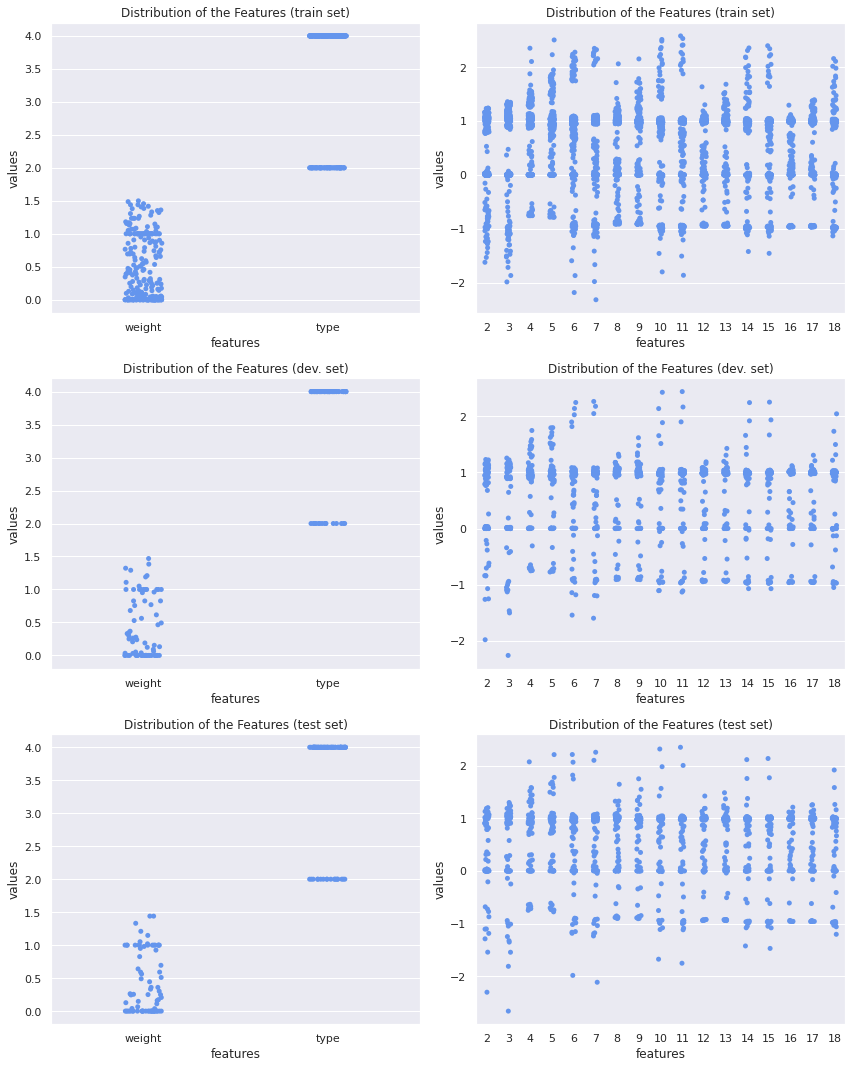

In [19]:
# create a unique dataframe with all values in one column and all column types associated as a second column
# e.g.:       | value | type
#          0  | 9.000 | weight
#          1  | 0.000 | weight
#          ...
#          333| 4.000 | type
#          334| 2.000 | type
#
cat_train_obs_types_pre_scl = pd.concat([pd.DataFrame({'value': train_slice[f].values, 'type': [f] * train_slice[f].shape[0]}) for f in train_slice.iloc[:,0:2]],
                                        axis = 0
                                       )
cat_train_lev_trunc_pre_scl = pd.concat([pd.DataFrame({'value': train_slice[f].values, 'type': [f] * train_slice[f].shape[0]}) for f in train_slice.iloc[:,2:]],
                                        axis = 0
                                       )
cat_dev_obs_types_pre_scl   = pd.concat([pd.DataFrame({'value': dev_slice[f].values, 'type': [f] * dev_slice[f].shape[0]}) for f in dev_slice.iloc[:,0:2]],
                                        axis = 0
                                       )
cat_dev_lev_trunc_pre_scl   = pd.concat([pd.DataFrame({'value': dev_slice[f].values, 'type': [f] * dev_slice[f].shape[0]}) for f in dev_slice.iloc[:,2:]],
                                        axis = 0
                                       )
cat_test_obs_types_pre_scl  = pd.concat([pd.DataFrame({'value': test_slice[f].values, 'type': [f] * test_slice[f].shape[0]}) for f in test_slice.iloc[:,0:2]],
                                        axis = 0
                                       )
cat_test_lev_trunc_pre_scl  = pd.concat([pd.DataFrame({'value': test_slice[f].values, 'type': [f] * test_slice[f].shape[0]}) for f in test_slice.iloc[:,2:]],
                                        axis = 0
                                       )

nrows = 3
ncols = 2
distrib_pre_scl_fig, distrib_pre_scl_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

sns.stripplot(data   = cat_train_obs_types_pre_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              ax     = distrib_pre_scl_plot[0,0]
             )
distrib_pre_scl_plot[0,0].set(title = 'Distribution of the Features (train set)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_train_lev_trunc_pre_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              order  = train_slice.columns[2:],
              ax     = distrib_pre_scl_plot[0,1]
             )
distrib_pre_scl_plot[0,1].set(title = 'Distribution of the Features (train set)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_dev_obs_types_pre_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              ax     = distrib_pre_scl_plot[1,0]
             )
distrib_pre_scl_plot[1,0].set(title = 'Distribution of the Features (dev. set)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_dev_lev_trunc_pre_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              order  = dev_slice.columns[2:],
              ax     = distrib_pre_scl_plot[1,1]
             )
distrib_pre_scl_plot[1,1].set(title = 'Distribution of the Features (dev. set)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_test_obs_types_pre_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              ax     = distrib_pre_scl_plot[2,0]
             )
distrib_pre_scl_plot[2,0].set(title = 'Distribution of the Features (test set)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_test_lev_trunc_pre_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              order  = test_slice.columns[2:],
              ax     = distrib_pre_scl_plot[2,1]
             )
distrib_pre_scl_plot[2,1].set(title = 'Distribution of the Features (test set)', xlabel = 'features', ylabel = 'values')

distrib_pre_scl_fig.tight_layout()
distrib_pre_scl_fig.savefig(path.join(IMG_PATH, 'distrib_pre_scl_low.pdf'), dpi = 300, format = 'pdf')
distrib_pre_scl_fig.savefig(path.join(IMG_PATH, 'distrib_pre_scl_low.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(distrib_pre_scl_fig)

The same can be done with the scaled data to compare the distributions with and without the scaling:

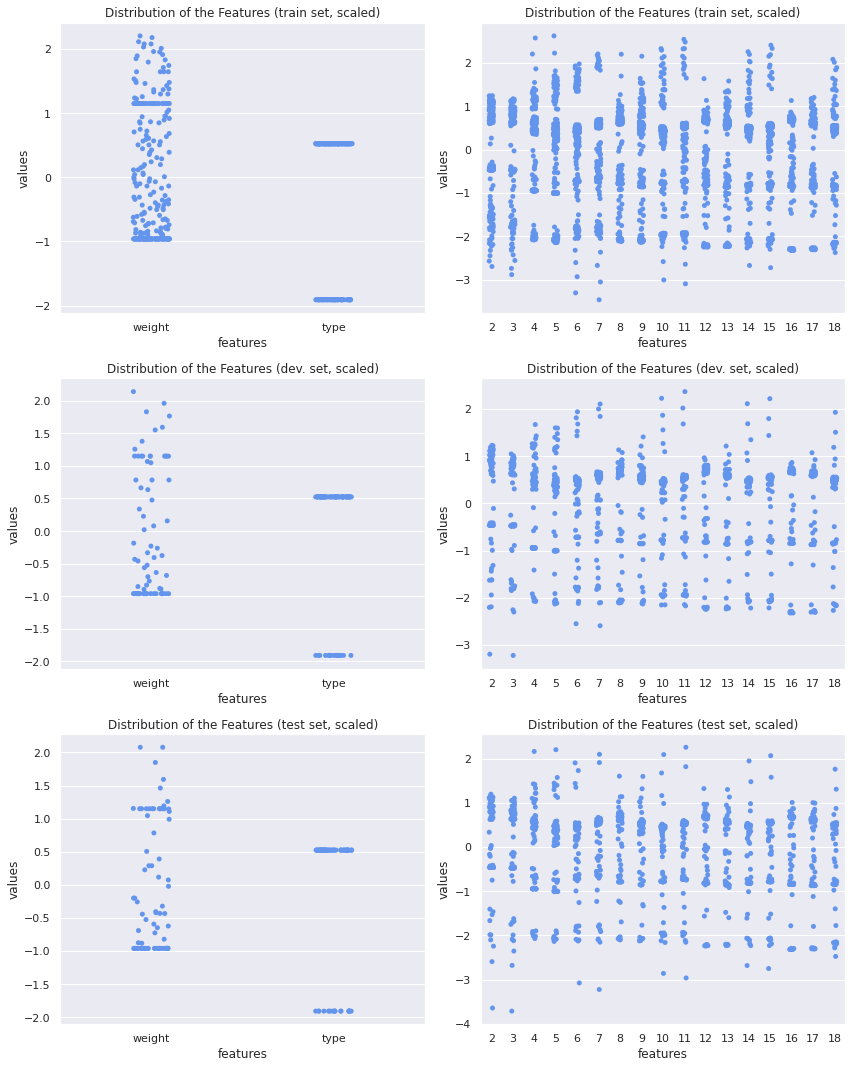

In [20]:
# build dataframes using the scaled data
train_slice_scl = pd.DataFrame(data = x_train, columns = train_slice.columns)
dev_slice_scl   = pd.DataFrame(data = x_dev,   columns = dev_slice.columns)
test_slice_scl  = pd.DataFrame(data = x_test,  columns = test_slice.columns)

# create a unique dataframe with all values in one column and all column types associated as a second column
cat_train_obs_types_post_scl = pd.concat([pd.DataFrame({'value': train_slice_scl[f].values, 'type': [f] * train_slice_scl[f].shape[0]}) for f in train_slice_scl.iloc[:,0:2]],
                                         axis = 0
                                        )
cat_train_lev_trunc_post_scl = pd.concat([pd.DataFrame({'value': train_slice_scl[f].values, 'type': [f] * train_slice_scl[f].shape[0]}) for f in train_slice_scl.iloc[:,2:]],
                                         axis = 0
                                        )
cat_dev_obs_types_post_scl   = pd.concat([pd.DataFrame({'value': dev_slice_scl[f].values, 'type': [f] * dev_slice_scl[f].shape[0]}) for f in dev_slice_scl.iloc[:,0:2]],
                                         axis = 0
                                        )
cat_dev_lev_trunc_post_scl   = pd.concat([pd.DataFrame({'value': dev_slice_scl[f].values, 'type': [f] * dev_slice_scl[f].shape[0]}) for f in dev_slice_scl.iloc[:,2:]],
                                         axis = 0
                                        )
cat_test_obs_types_post_scl  = pd.concat([pd.DataFrame({'value': test_slice_scl[f].values, 'type': [f] * test_slice_scl[f].shape[0]}) for f in test_slice_scl.iloc[:,0:2]],
                                         axis = 0
                                        )
cat_test_lev_trunc_post_scl  = pd.concat([pd.DataFrame({'value': test_slice_scl[f].values, 'type': [f] * test_slice_scl[f].shape[0]}) for f in test_slice_scl.iloc[:,2:]],
                                         axis = 0
                                        )

nrows = 3
ncols = 2
distrib_post_scl_fig, distrib_post_scl_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

sns.stripplot(data   = cat_train_obs_types_post_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              ax     = distrib_post_scl_plot[0,0]
             )
distrib_post_scl_plot[0,0].set(title = 'Distribution of the Features (train set, scaled)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_train_lev_trunc_post_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              order  = train_slice.columns[2:],
              ax     = distrib_post_scl_plot[0,1]
             )
distrib_post_scl_plot[0,1].set(title = 'Distribution of the Features (train set, scaled)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_dev_obs_types_post_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              ax     = distrib_post_scl_plot[1,0]
             )
distrib_post_scl_plot[1,0].set(title = 'Distribution of the Features (dev. set, scaled)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_dev_lev_trunc_post_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              order  = dev_slice.columns[2:],
              ax     = distrib_post_scl_plot[1,1]
             )
distrib_post_scl_plot[1,1].set(title = 'Distribution of the Features (dev. set, scaled)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_test_obs_types_post_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              ax     = distrib_post_scl_plot[2,0]
             )
distrib_post_scl_plot[2,0].set(title = 'Distribution of the Features (test set, scaled)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_test_lev_trunc_post_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              order  = test_slice.columns[2:],
              ax     = distrib_post_scl_plot[2,1]
             )
distrib_post_scl_plot[2,1].set(title = 'Distribution of the Features (test set, scaled)', xlabel = 'features', ylabel = 'values')

distrib_post_scl_fig.tight_layout()
distrib_post_scl_fig.savefig(path.join(IMG_PATH, 'distrib_post_scl_low.pdf'), dpi = 300, format = 'pdf')
distrib_post_scl_fig.savefig(path.join(IMG_PATH, 'distrib_post_scl_low.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(distrib_post_scl_fig)

We can also compute the previous feature plot to show the distribution of the features for the **training set**:

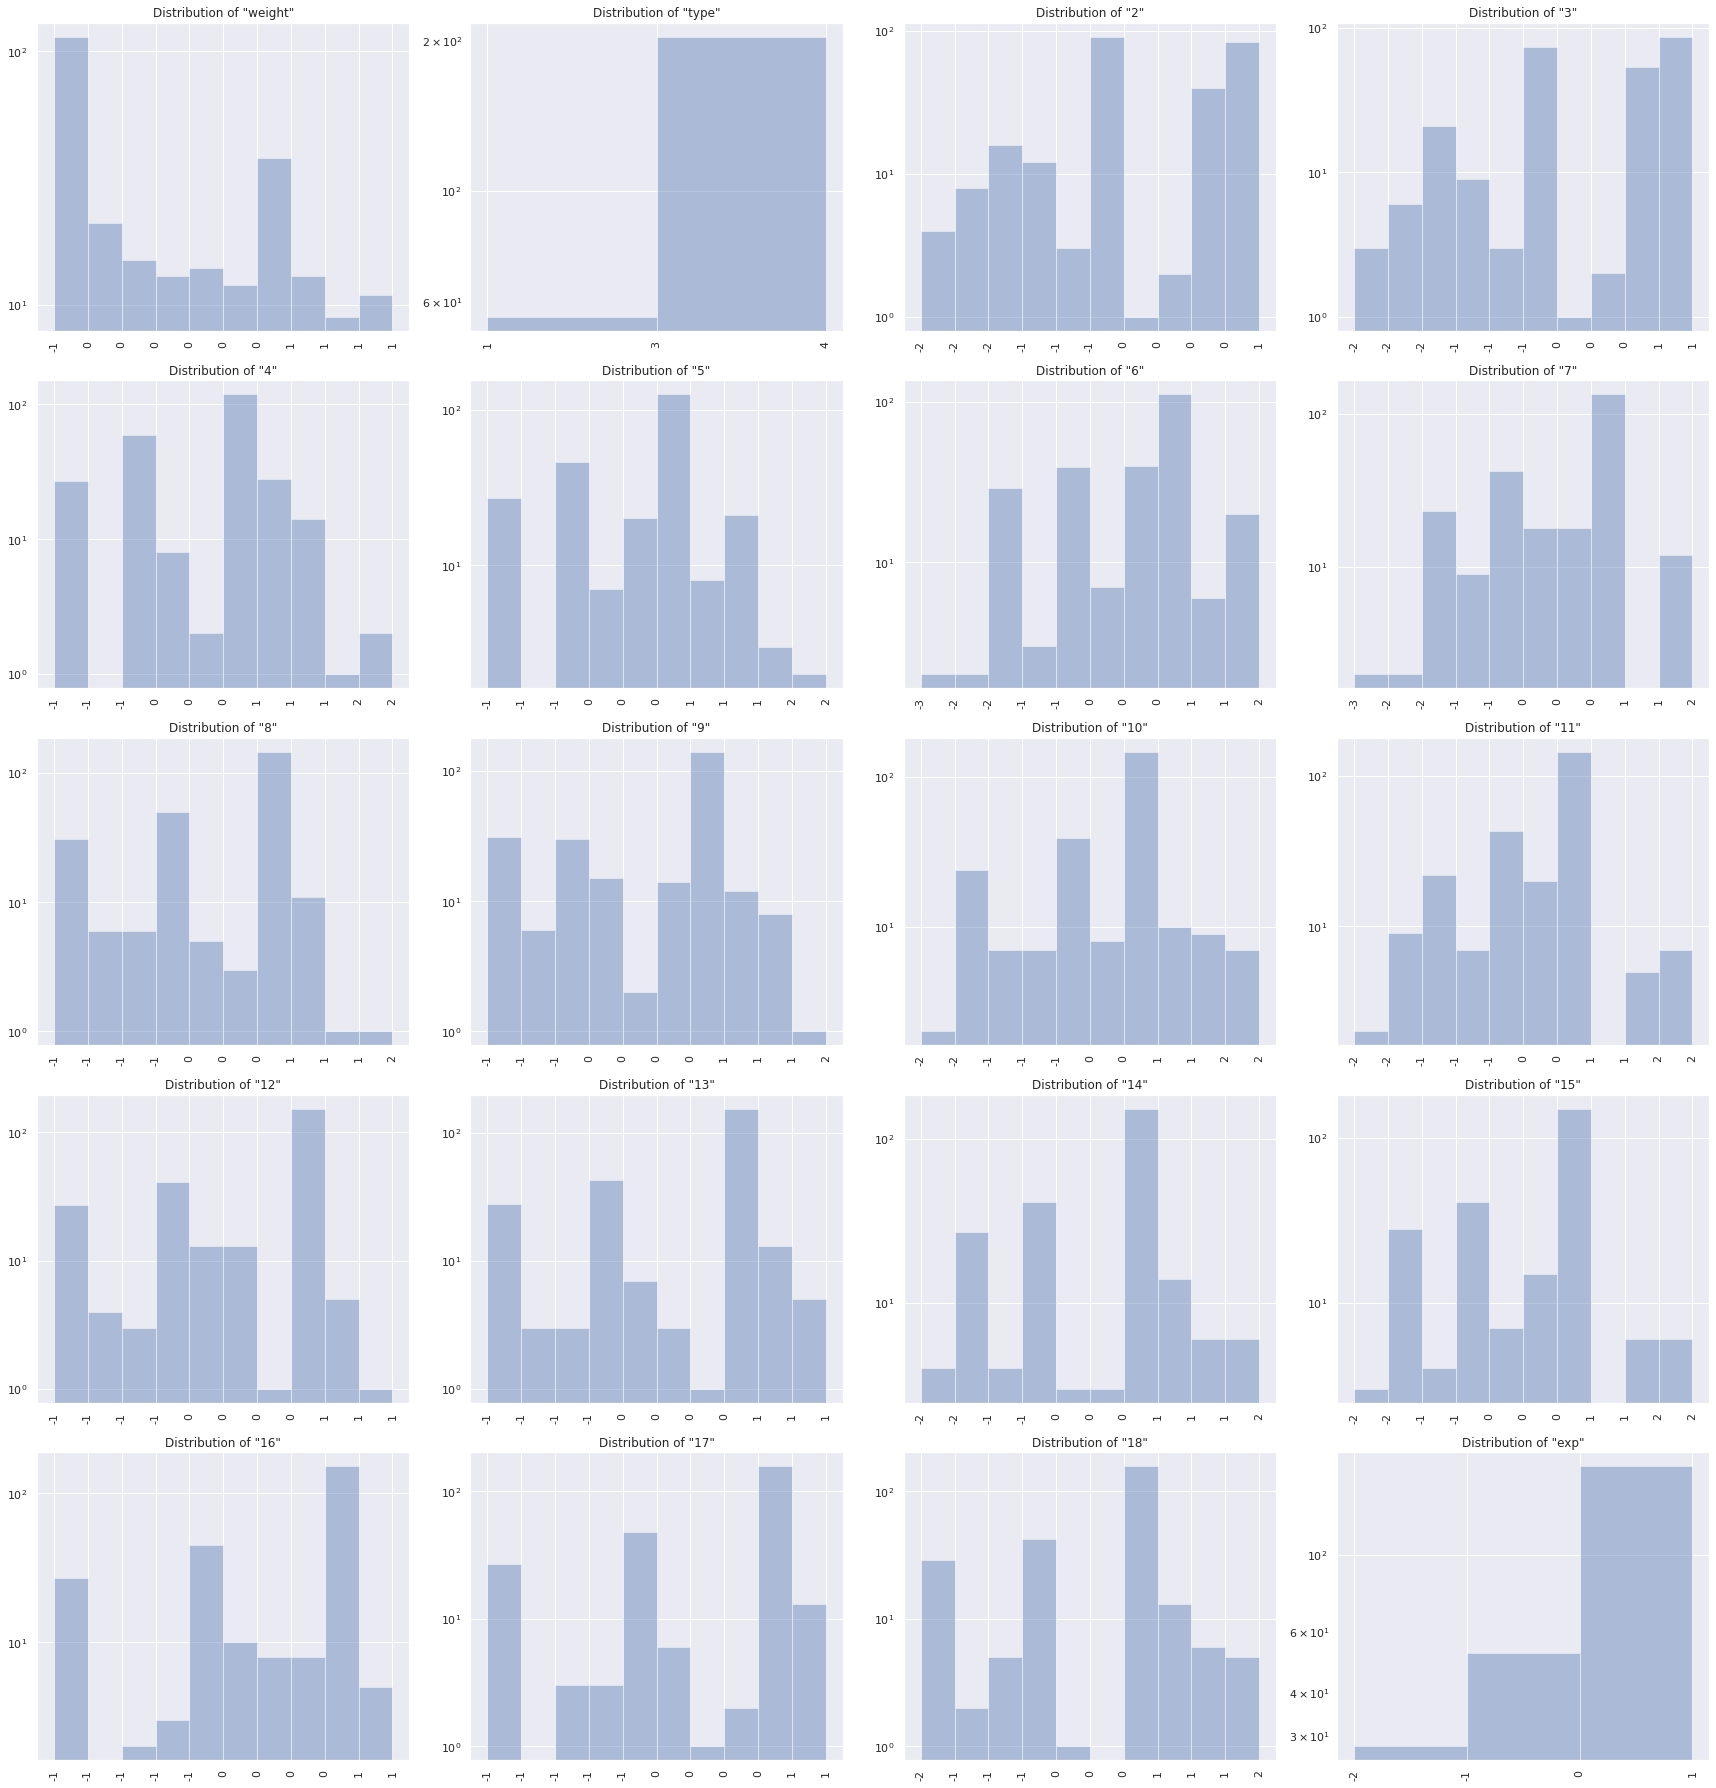

In [21]:
# define a version of the dataframe with only useful column for the plot
df_feature_plot = df_train.drop(columns = ['init', 'system'])
    
# now draw a grid of histograms
ncols = 4
nrows = 5

# choose the number of bins
n_bins = 10

# take the names of the feature sand distribute them in the grid
features = np.array(df_feature_plot.columns).reshape(nrows, ncols)

# create the plot
distr_feature_fig, distr_feature_plot = plt.subplots(ncols = ncols, nrows = nrows, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

for i in range(nrows):
    for j in range(ncols):
        digitize_plot(df_feature_plot[features[i,j]], n_bins, distr_feature_plot[i,j])

distr_feature_fig.tight_layout()
distr_feature_fig.savefig(path.join(IMG_PATH, 'distr_train_feature_low.pdf'), dpi = 300, format = 'pdf')
distr_feature_fig.savefig(path.join(IMG_PATH, 'distr_train_feature_low.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(distr_feature_fig)

## Linear Regression

In [22]:
optimization = True #-------------------------------------------- choose whether to use optimisation

hyp_opt    = {'fit_intercept': [False, True]} #------------------ hypeparameter optimization
hyp_choice = {'fit_intercept': True} #--------------------------- a choice of hyperparameters (use if optimization = False)

log.info('Fitting LINEAR REGRESSION.')

if optimization:
    lin_reg_model, lin_reg_params, lin_reg_pred, lin_reg_mtr, lin_reg_cint = analysis.linear_regression(hyp_opt, optimization = optimization)
    print('Best hyperparameters:\n')
    pretty_print(lin_reg_params)
else:
    lin_reg_model, lin_reg_pred, lin_reg_mtr, lin_reg_cint = analysis.linear_regression(hyp_choice, optimization = optimization)
    print('Hyperparameters:\n')
    pretty_print(hyp_choice)
    
print('Metrics:\n')
pretty_print(lin_reg_mtr)

print('Confidence intervals of the MSE (CI 95%):\n')
pretty_print(lin_reg_cint)
    
log.debug('End of the fit.')

Best hyperparameters:

FIT INTERCEPT = True


Metrics:

MAE train SET = 0.023811824408942167
MAE dev SET = 0.033493847233843785
MAE test SET = 0.14632724118569962
MSE train SET = 0.0035603367303308803
MSE dev SET = 0.004981327372893452
MSE test SET = 0.21286600209234674
R2 train SET = 0.9922301535714628
R2 dev SET = 0.9891625948772489
R2 test SET = 0.5599433310998871
EVR train SET = 0.9922301535714628
EVR dev SET = 0.9891742537701833
EVR test SET = 0.5621951679903467


Confidence intervals of the MSE (CI 95%):

train SET = (array([8.87621929e-05]), array([0.00703191]))
dev SET = (array([0.00020444]), array([0.00975822]))
test SET = (array([-0.04421607]), array([0.46994807]))




We then visualise the errors made on the development and test sets:

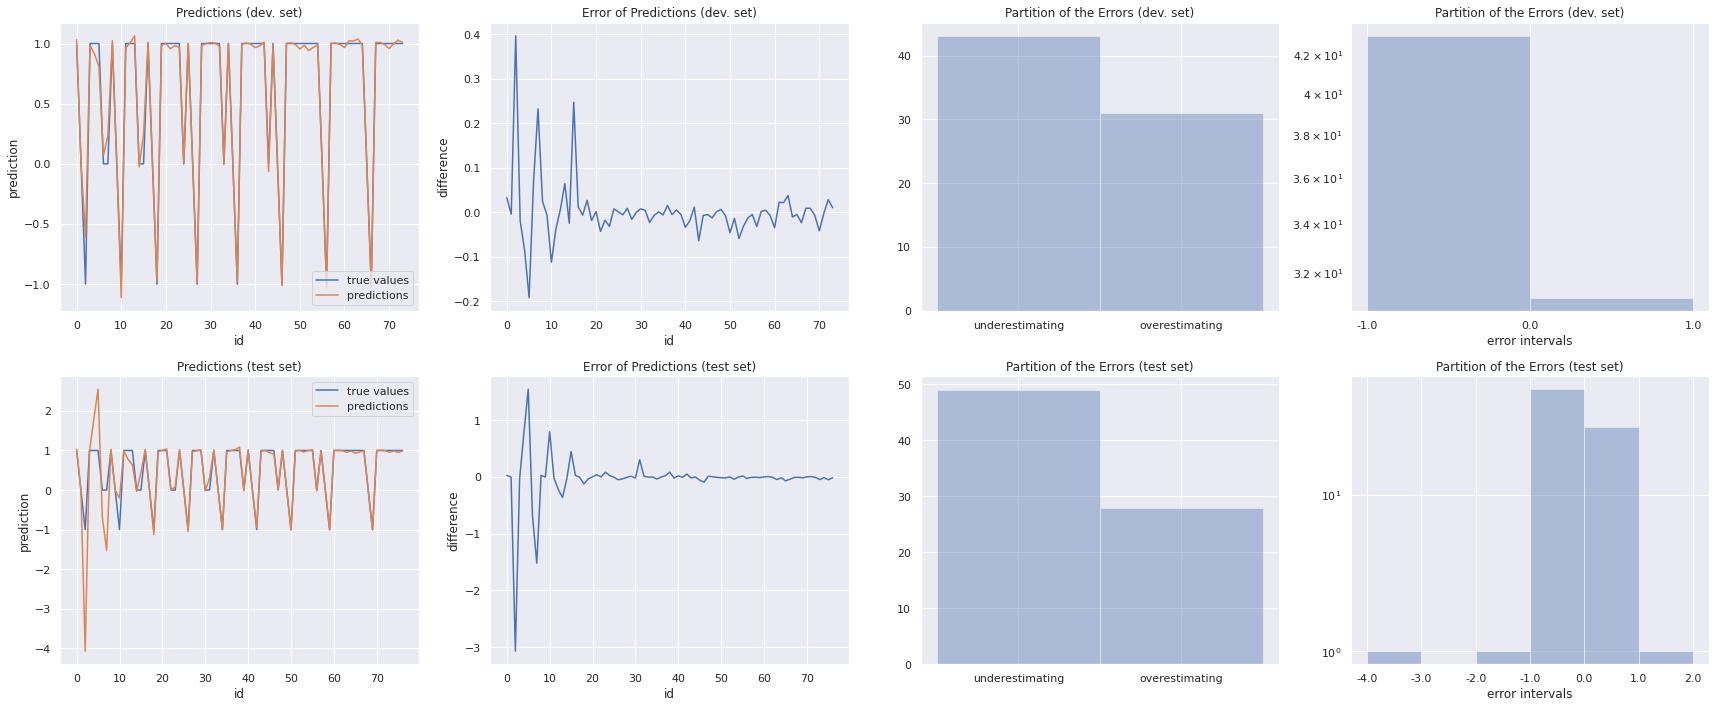

In [23]:
dev_length          = y_dev.shape[0]
test_length         = y_test.shape[0]
lin_reg_dev_errors  = lin_reg_pred['y_dev_pred'] - y_dev
lin_reg_test_errors = lin_reg_pred['y_test_pred'] - y_test

nrows = 2
ncols = 4
lin_reg_fig, lin_reg_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

# plot dev set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = y_dev.reshape(-1,),
             label = 'true values',
             ax    = lin_reg_plot[0,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = lin_reg_pred['y_dev_pred'].reshape(-1,),
             label = 'predictions',
             ax    = lin_reg_plot[0,0]
            )
lin_reg_plot[0,0].set(title = 'Predictions (dev. set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y  = lin_reg_dev_errors.reshape(-1,),
             ax = lin_reg_plot[0,1]
            )
lin_reg_plot[0,1].set(title = 'Error of Predictions (dev. set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(lin_reg_dev_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = lin_reg_plot[0,2]
            )
lin_reg_plot[0,2].set(title = 'Partition of the Errors (dev. set)', xticks = [0, 1])
lin_reg_plot[0,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(lin_reg_dev_errors.min()), np.ceil(lin_reg_dev_errors.max()) + n, 1)
sns.distplot(np.digitize(lin_reg_dev_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = lin_reg_plot[0,3]
            )
lin_reg_plot[0,3].set(title = 'Partition of the Errors (dev. set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
lin_reg_plot[0,3].set_xticklabels(list(bins(1)))

# plot test set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = y_test.reshape(-1,),
             label = 'true values',
             ax    = lin_reg_plot[1,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = lin_reg_pred['y_test_pred'].reshape(-1,),
             label = 'predictions',
             ax    = lin_reg_plot[1,0]
            )
lin_reg_plot[1,0].set(title = 'Predictions (test set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y  = lin_reg_test_errors.reshape(-1,),
             ax = lin_reg_plot[1,1]
            )
lin_reg_plot[1,1].set(title = 'Error of Predictions (test set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(lin_reg_test_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = lin_reg_plot[1,2]
            )
lin_reg_plot[1,2].set(title = 'Partition of the Errors (test set)', xticks = [0, 1])
lin_reg_plot[1,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(lin_reg_test_errors.min()), np.ceil(lin_reg_test_errors.max()) + n, 1)
sns.distplot(np.digitize(lin_reg_test_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = lin_reg_plot[1,3]
            )
lin_reg_plot[1,3].set(title = 'Partition of the Errors (test set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
lin_reg_plot[1,3].set_xticklabels(list(bins(1)))

lin_reg_fig.tight_layout()
lin_reg_fig.savefig(path.join(IMG_PATH, 'lin_reg_low.pdf'), dpi = 300, format = 'pdf')
lin_reg_fig.savefig(path.join(IMG_PATH, 'lin_reg_low.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(lin_reg_fig)

### Random Forests

In [24]:
from skopt.space import Integer, Real, Categorical

optimization = True #--------------------------------------------------------- choose whether to use optimisation

hyp_opt    = [Integer(2, 100,                             name = 'num_leaves'),
              Integer(50, 300,                            name = 'max_depth'),
              Integer(2, 100,                             name = 'n_estimators'),
              Real(0.1, 0.99,                             name = 'subsample'),
              Real(0.7, 1.0,                              name = 'colsample_bytree'),
              Real(1.0e-6, 1.0e-2, prior = 'log-uniform', name = 'min_child_weight'),
              Real(1.0e0, 1.0e2,   prior = 'log-uniform', name = 'reg_alpha'),
              Real(1.0e0, 1.0e2,   prior = 'log-uniform', name = 'reg_lambda')
             ] #-------------------------------------------------------------- hypeparameter optimization
hyp_choice = {'num_leaves':        15,
              'max_depth':         45,
              'n_estimators':      15,
              'min_child_weight':  1.0e-2,
              'subsample':         0.9,
              'colsample_bytree':  0.9,
              'reg_alpha':         1.0e-3,
              'reg_lambda':        1.0e-3
             } #-------------------------------------------------------------- a choice of hyperparameters (use if optimization = False)

log.info('Fitting RANDOM FOREST.')

if optimization:
    rnd_for_model, rnd_for_params, rnd_for_pred, rnd_for_mtr, rnd_for_cint = analysis.random_forest(hyp_opt, optimization = optimization, n_calls = 15)
    print('Best hyperparameters:\n')
    pretty_print(rnd_for_params)
else:
    rnd_for_model, rnd_for_pred, rnd_for_mtr, rnd_for_cint = analysis.random_forest(hyp_choice, optimization = optimization)
    print('Hyperparameters:\n')
    pretty_print(hyp_choice)
        
print('Metrics:\n')
pretty_print(rnd_for_mtr)

print('Confidence intervals of the MSE (CI 95%):\n')
pretty_print(rnd_for_cint)
    
log.debug('End of the fit.')

Best hyperparameters:

NUM LEAVES       = 8
MAX DEPTH        = 50
N ESTIMATORS     = 29
SUBSAMPLE        = 0.4776587248378936
COLSAMPLE BYTREE = 0.854270815097951
MIN CHILD WEIGHT = 0.01
REG ALPHA        = 2.3436433890192334
REG LAMBDA       = 1.0


Metrics:

MAE train SET = 0.18445347214501404
MAE dev SET = 0.17573091672917376
MAE test SET = 0.24011253393198292
MSE train SET = 0.09345580151262595
MSE dev SET = 0.07491134493752266
MSE test SET = 0.1396326219911137
R2 train SET = 0.7960481604386134
R2 dev SET = 0.8370224374740269
R2 test SET = 0.7113382790148839
EVR train SET = 0.7960553779985243
EVR dev SET = 0.8370296156445479
EVR test SET = 0.7130055390820809


Confidence intervals of the MSE (CI 95%):

train SET = (array([0.05940422]), array([0.12750738]))
dev SET = (array([0.03750769]), array([0.112315]))
test SET = (array([0.06374314]), array([0.21552211]))




We then plot the errors:

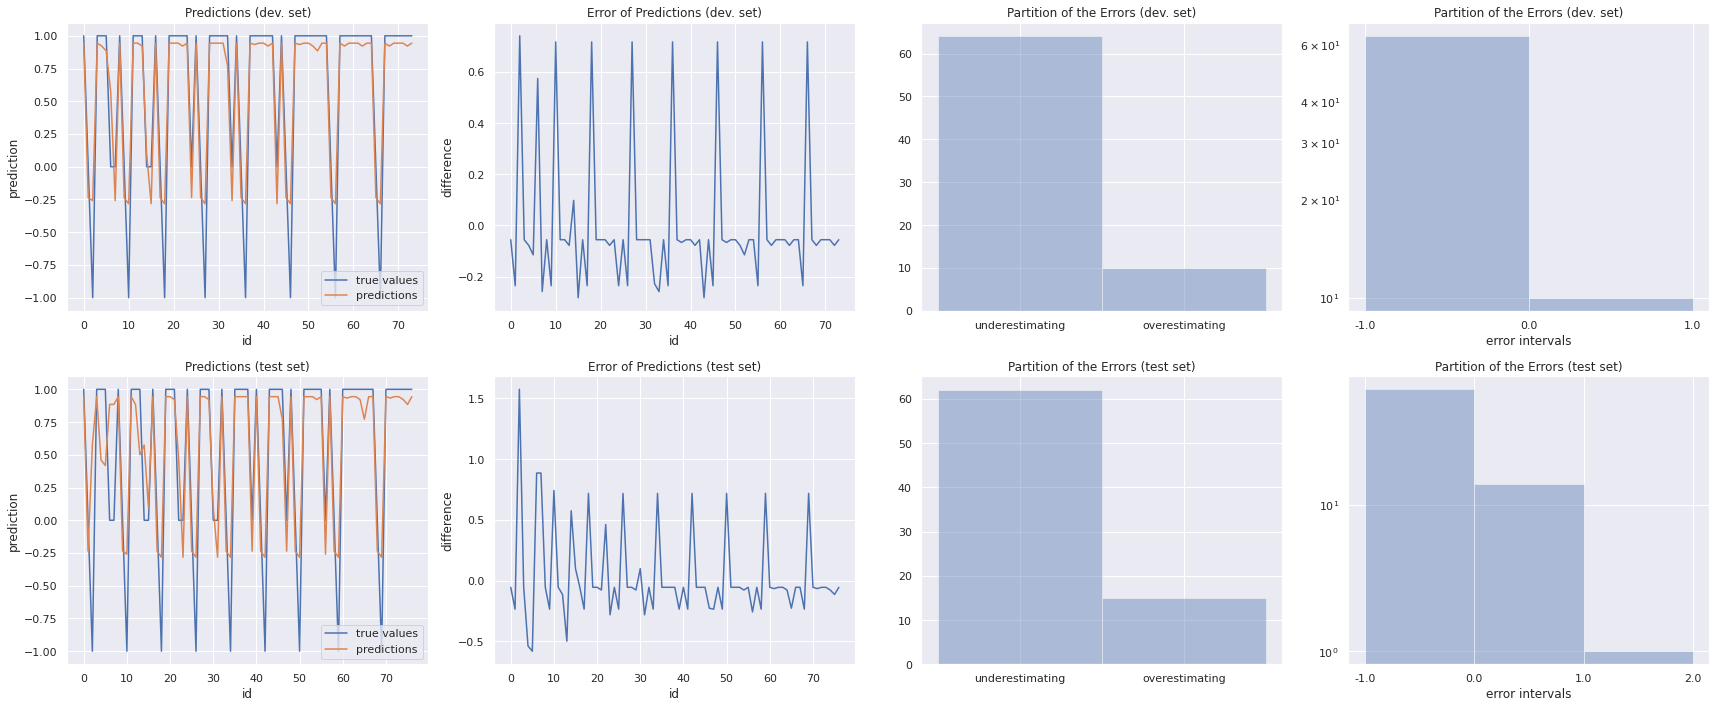

In [25]:
dev_length        = y_dev.shape[0]
test_length       = y_test.shape[0]
rnd_for_dev_errors  = rnd_for_pred['y_dev_pred'] - y_dev
rnd_for_test_errors = rnd_for_pred['y_test_pred'] - y_test

nrows = 2
ncols = 4
rnd_for_fig, rnd_for_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

# plot dev set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = y_dev.reshape(-1,),
             label = 'true values',
             ax    = rnd_for_plot[0,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = rnd_for_pred['y_dev_pred'].reshape(-1,),
             label = 'predictions',
             ax    = rnd_for_plot[0,0]
            )
rnd_for_plot[0,0].set(title = 'Predictions (dev. set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y  = rnd_for_dev_errors.reshape(-1,),
             ax = rnd_for_plot[0,1]
            )
rnd_for_plot[0,1].set(title = 'Error of Predictions (dev. set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(rnd_for_dev_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = rnd_for_plot[0,2]
            )
rnd_for_plot[0,2].set(title = 'Partition of the Errors (dev. set)', xticks = [0, 1])
rnd_for_plot[0,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(rnd_for_dev_errors.min()), np.ceil(rnd_for_dev_errors.max()) + n, 1)
sns.distplot(np.digitize(rnd_for_dev_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = rnd_for_plot[0,3]
            )
rnd_for_plot[0,3].set(title = 'Partition of the Errors (dev. set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
rnd_for_plot[0,3].set_xticklabels(list(bins(1)))

# plot test set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = y_test.reshape(-1,),
             label = 'true values',
             ax    = rnd_for_plot[1,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = rnd_for_pred['y_test_pred'].reshape(-1,),
             label = 'predictions',
             ax    = rnd_for_plot[1,0]
            )
rnd_for_plot[1,0].set(title = 'Predictions (test set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y  = rnd_for_test_errors.reshape(-1,),
             ax = rnd_for_plot[1,1]
            )
rnd_for_plot[1,1].set(title = 'Error of Predictions (test set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(rnd_for_test_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = rnd_for_plot[1,2]
            )
rnd_for_plot[1,2].set(title = 'Partition of the Errors (test set)', xticks = [0, 1])
rnd_for_plot[1,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(rnd_for_test_errors.min()), np.ceil(rnd_for_test_errors.max()) + n, 1)
sns.distplot(np.digitize(rnd_for_test_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = rnd_for_plot[1,3]
            )
rnd_for_plot[1,3].set(title = 'Partition of the Errors (test set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
rnd_for_plot[1,3].set_xticklabels(list(bins(1)))

rnd_for_fig.tight_layout()
rnd_for_fig.savefig(path.join(IMG_PATH, 'rnd_for_low.pdf'), dpi = 300, format = 'pdf')
rnd_for_fig.savefig(path.join(IMG_PATH, 'rnd_for_low.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(rnd_for_fig)

### Gradient Boosted Trees

In [26]:
from skopt.space import Integer, Real, Categorical

optimization = True #--------------------------------------------------------- choose whether to use optimisation

hyp_opt    = [Integer(2, 50,                              name = 'num_leaves'),
              Integer(2, 25,                              name = 'max_depth'),
              Integer(1e1, 4e3,    prior = 'log-uniform', name = 'n_estimators'),
              Real(0.1, 0.99,                             name = 'subsample'),
              Real(0.1, 1.0,                              name = 'colsample_bytree'),
              Real(1.0e-3, 1.0e-1, prior = 'log-uniform', name = 'min_child_weight'),
              Real(1.0e0, 1.0e2,  prior = 'log-uniform',  name = 'reg_alpha'),
              Real(1.0e0, 1.0e3,   prior = 'log-uniform', name = 'reg_lambda')
             ] #-------------------------------------------------------------- hypeparameter optimization
hyp_choice = {'num_leaves':        15,
              'max_depth':         45,
              'n_estimators':      500,
              'min_child_weight':  1.0e-2,
              'subsample':         0.9,
              'colsample_bytree':  0.9,
              'reg_alpha':         1.0e-3,
              'reg_lambda':        1.0e-3
             } #-------------------------------------------------------------- a choice of hyperparameters (use if optimization = False)

log.info('Fitting BOOSTED TREES.')

if optimization:
    grd_boost_model, grd_boost_params, grd_boost_pred, grd_boost_mtr, grd_boost_cint = analysis.gradient_boosting(hyp_opt, optimization = optimization, n_calls = 15)
    print('Best hyperparameters:\n')
    pretty_print(grd_boost_params)
else:
    grd_boost_model, grd_boost_pred, grd_boost_mtr, grd_boost_cint = analysis.gradient_boosting(hyp_choice, optimization = optimization)
    print('Hyperparameters:\n')
    pretty_print(hyp_choice)
        
print('Metrics:\n')
pretty_print(grd_boost_mtr)

print('Confidence intervals of the MSE (CI 95%):\n')
pretty_print(grd_boost_cint)
    
log.debug('End of the fit.')

Best hyperparameters:

NUM LEAVES       = 50
MAX DEPTH        = 2
N ESTIMATORS     = 4000
SUBSAMPLE        = 0.99
COLSAMPLE BYTREE = 1.0
MIN CHILD WEIGHT = 0.001
REG ALPHA        = 1.0
REG LAMBDA       = 1.0


Metrics:

MAE train SET = 0.03452730663107852
MAE dev SET = 0.031996588745238974
MAE test SET = 0.09335212431403053
MSE train SET = 0.010189146159214353
MSE dev SET = 0.0029245516247509836
MSE test SET = 0.047283573218907894
R2 train SET = 0.9777638726639046
R2 dev SET = 0.9936373282887817
R2 test SET = 0.902250939464817
EVR train SET = 0.9777638866972712
EVR dev SET = 0.9936569444742702
EVR test SET = 0.9022566186377224


Confidence intervals of the MSE (CI 95%):

train SET = (array([-2.00157095e-05]), array([0.02039831]))
dev SET = (array([0.00100873]), array([0.00484038]))
test SET = (array([0.01071735]), array([0.0838498]))




We then plot the errors:

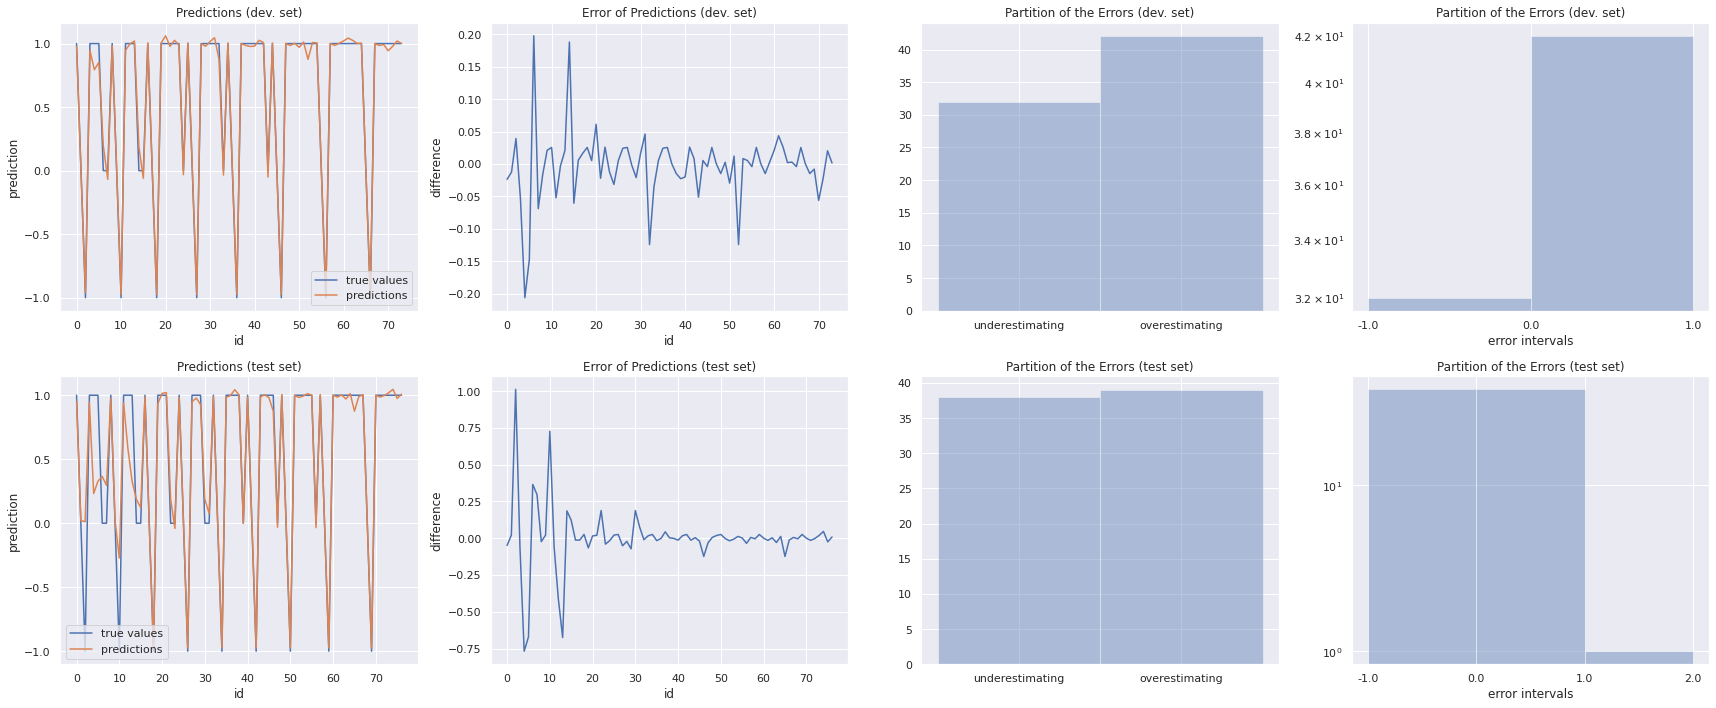

In [27]:
dev_length            = y_dev.shape[0]
test_length           = y_test.shape[0]
grd_boost_dev_errors  = grd_boost_pred['y_dev_pred'] - y_dev
grd_boost_test_errors = grd_boost_pred['y_test_pred'] - y_test

nrows = 2
ncols = 4
grd_boost_fig, grd_boost_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

# plot dev set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = y_dev.reshape(-1,),
             label = 'true values',
             ax    = grd_boost_plot[0,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = grd_boost_pred['y_dev_pred'].reshape(-1,),
             label = 'predictions',
             ax    = grd_boost_plot[0,0]
            )
grd_boost_plot[0,0].set(title = 'Predictions (dev. set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y  = grd_boost_dev_errors.reshape(-1,),
             ax = grd_boost_plot[0,1]
            )
grd_boost_plot[0,1].set(title = 'Error of Predictions (dev. set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(grd_boost_dev_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = grd_boost_plot[0,2]
            )
grd_boost_plot[0,2].set(title = 'Partition of the Errors (dev. set)', xticks = [0, 1])
grd_boost_plot[0,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(grd_boost_dev_errors.min()), np.ceil(grd_boost_dev_errors.max()) + n, 1)
sns.distplot(np.digitize(grd_boost_dev_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = grd_boost_plot[0,3]
            )
grd_boost_plot[0,3].set(title = 'Partition of the Errors (dev. set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
grd_boost_plot[0,3].set_xticklabels(list(bins(1)))

# plot test set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = y_test.reshape(-1,),
             label = 'true values',
             ax    = grd_boost_plot[1,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = grd_boost_pred['y_test_pred'].reshape(-1,),
             label = 'predictions',
             ax    = grd_boost_plot[1,0]
            )
grd_boost_plot[1,0].set(title = 'Predictions (test set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y  = grd_boost_test_errors.reshape(-1,),
             ax = grd_boost_plot[1,1]
            )
grd_boost_plot[1,1].set(title = 'Error of Predictions (test set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(grd_boost_test_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = grd_boost_plot[1,2]
            )
grd_boost_plot[1,2].set(title = 'Partition of the Errors (test set)', xticks = [0, 1])
grd_boost_plot[1,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(grd_boost_test_errors.min()), np.ceil(grd_boost_test_errors.max()) + n, 1)
sns.distplot(np.digitize(grd_boost_test_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = grd_boost_plot[1,3]
            )
grd_boost_plot[1,3].set(title = 'Partition of the Errors (test set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
grd_boost_plot[1,3].set_xticklabels(list(bins(1)))

grd_boost_fig.tight_layout()
grd_boost_fig.savefig(path.join(IMG_PATH, 'grd_boost_low.pdf'), dpi = 300, format = 'pdf')
grd_boost_fig.savefig(path.join(IMG_PATH, 'grd_boost_low.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(grd_boost_fig)

# _A Posteriori_ Analysis

From the predictions of the models, it seems that tree based algorithms are the best at the task, while linear models (and linear SVR) usually do not approximate well the data and Gaussian SVR and ANN overfit the development set.

We propose here an analysis of the RF and GBDT using a **SHAP** approach to better understand the factors entering the output of the models:

In [28]:
import shap

rf_exp   = shap.TreeExplainer(rnd_for_model) #------------------ tree explainer for RF
gbdt_exp = shap.TreeExplainer(grd_boost_model) #---------------- tree explainer for GBDT

We then compute the SHAP values for the test slice (the `pandas` version of the `numpy` matrix used for predictions: this also contains the name of the columns):

In [29]:
rf_shap_values = rf_exp.shap_values(test_slice) #--------------- extract Shapley values for RF
gbdt_shap_values = gbdt_exp.shap_values(test_slice) #----------- extract Shapley values for GBDT

Finally we plot the contribution of each feature to the final result of the RF:

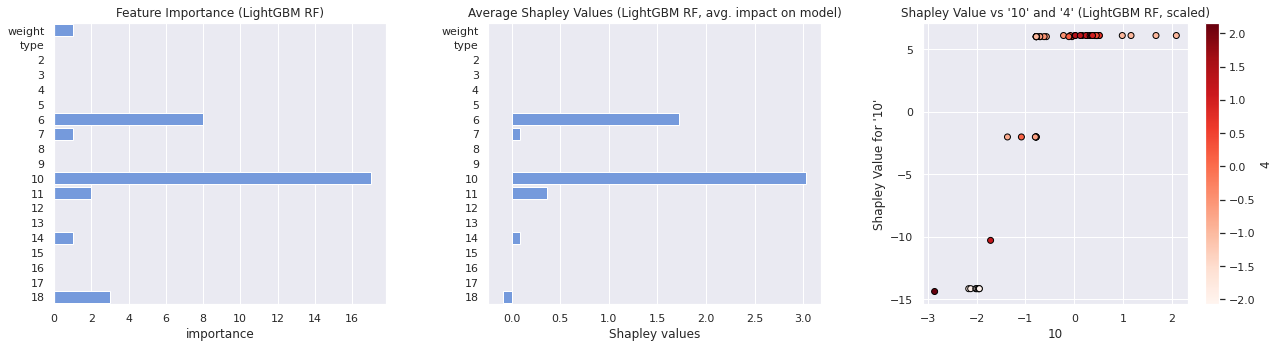

In [30]:
nrows = 1
ncols = 3
rf_shap_fig, rf_shap_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

rf_feat_imp  = {'features':         list(test_slice.columns),
                'tree_importance':  rnd_for_model.feature_importances_.reshape(-1,),
                'shap_values':      rf_shap_values,
                'mean_shap_values': rf_shap_values.mean(axis = 0).reshape(-1,)
               }

sns.barplot(data   = rf_feat_imp,
            x      = 'tree_importance',
            y      = 'features',
            color  = 'cornflowerblue',
            ax     = rf_shap_plot[0]
           )
rf_shap_plot[0].set(title = 'Feature Importance (LightGBM RF)', xlabel = 'importance')

sns.barplot(data   = rf_feat_imp,
            x      = 'mean_shap_values',
            y      = 'features',
            color  = 'cornflowerblue',
            ax     = rf_shap_plot[1]
           )
rf_shap_plot[1].set(title = 'Average Shapley Values (LightGBM RF, avg. impact on model)', xlabel = 'Shapley values')

scatter = rf_shap_plot[2].scatter(x         = x_test[:,10].reshape(-1,),
                                  y         = rf_shap_values[:,10].reshape(-1,),
                                  c         = x_test[:,4].reshape(-1,),
                                  vmin      = x_test[:,4].reshape(-1,).min(),
                                  vmax      = x_test[:,4].reshape(-1,).max(),
                                  cmap      = 'Reds',
                                  edgecolor = 'black'
                                 )
rf_shap_fig.colorbar(scatter, ax = rf_shap_plot[2], label = '4')
rf_shap_plot[2].set(title = 'Shapley Value vs \'10\' and \'4\' (LightGBM RF, scaled)', xlabel = '10', ylabel = 'Shapley Value for \'10\'')

rf_shap_fig.tight_layout()
rf_shap_fig.savefig(path.join(IMG_PATH, 'rf_shap_low.pdf'), dpi = 300, format = 'pdf')
rf_shap_fig.savefig(path.join(IMG_PATH, 'rf_shap_low.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(rf_shap_fig)

We then do the same for the GBDT:

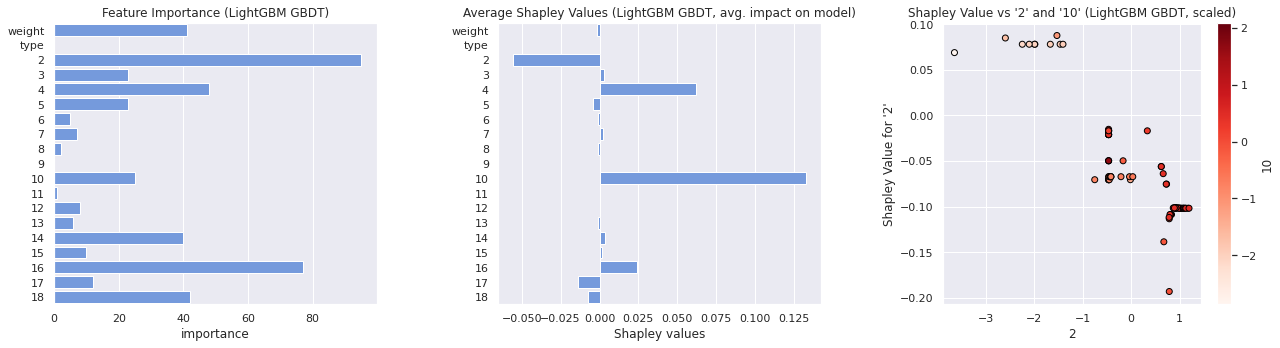

In [31]:
nrows = 1
ncols = 3
gbdt_shap_fig, gbdt_shap_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

gbdt_feat_imp  = {'features':         list(test_slice.columns),
                  'tree_importance':  grd_boost_model.feature_importances_.reshape(-1,),
                  'shap_values':      gbdt_shap_values,
                  'mean_shap_values': gbdt_shap_values.mean(axis = 0).reshape(-1,)
                 }

sns.barplot(data   = gbdt_feat_imp,
            x      = 'tree_importance',
            y      = 'features',
            color  = 'cornflowerblue',
            ax     = gbdt_shap_plot[0]
           )
gbdt_shap_plot[0].set(title = 'Feature Importance (LightGBM GBDT)', xlabel = 'importance')

sns.barplot(data   = gbdt_feat_imp,
            x      = 'mean_shap_values',
            y      = 'features',
            color  = 'cornflowerblue',
            ax     = gbdt_shap_plot[1]
           )
gbdt_shap_plot[1].set(title = 'Average Shapley Values (LightGBM GBDT, avg. impact on model)', xlabel = 'Shapley values')

scatter = gbdt_shap_plot[2].scatter(x         = x_test[:,2].reshape(-1,),
                                    y         = gbdt_shap_values[:,2].reshape(-1,),
                                    c         = x_test[:,10].reshape(-1,),
                                    vmin      = x_test[:,10].reshape(-1,).min(),
                                    vmax      = x_test[:,10].reshape(-1,).max(),
                                    cmap      = 'Reds',
                                    edgecolor = 'black'
                                   )
gbdt_shap_fig.colorbar(scatter, ax = gbdt_shap_plot[2], label = '10')
gbdt_shap_plot[2].set(title = 'Shapley Value vs \'2\' and \'10\' (LightGBM GBDT, scaled)', xlabel = '2', ylabel = 'Shapley Value for \'2\'')

gbdt_shap_fig.tight_layout()
gbdt_shap_fig.savefig(path.join(IMG_PATH, 'gbdt_shap_low.pdf'), dpi = 300, format = 'pdf')
gbdt_shap_fig.savefig(path.join(IMG_PATH, 'gbdt_shap_low.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(gbdt_shap_fig)

# Output

Finally we save the output predictions and models to file for further use:

In [32]:
# create dataframe for training predictions
df_train_pred = pd.DataFrame({'system':    df_train['system'].values.reshape(-1,),
                              'init':      df_train['init'].values.reshape(-1,),
                              'weight':    df_train['weight'].values.reshape(-1,),
                              'type':      df_train['type'].values.reshape(-1,),
                              'lin_reg':   lin_reg_pred['y_train_pred'].reshape(-1,),
                              'rnd_for':   rnd_for_pred['y_train_pred'].reshape(-1,),
                              'grd_boost': grd_boost_pred['y_train_pred'].reshape(-1,),
                              'exp':       y_train.reshape(-1,)
                             }, index = df_train.index).sort_index(ignore_index = True)

# create dataframe for validation predictions
df_dev_pred   = pd.DataFrame({'system':    df_dev['system'].values.reshape(-1,),
                              'init':      df_dev['init'].values.reshape(-1,),
                              'weight':    df_dev['weight'].values.reshape(-1,),
                              'type':      df_dev['type'].values.reshape(-1,),
                              'lin_reg':   lin_reg_pred['y_dev_pred'].reshape(-1,),
                              'rnd_for':   rnd_for_pred['y_dev_pred'].reshape(-1,),
                              'grd_boost': grd_boost_pred['y_dev_pred'].reshape(-1,),
                              'exp':       y_dev.reshape(-1,)
                             }, index = df_dev.index).sort_index(ignore_index = True)

# create dataframe for test predictions
df_test_pred  = pd.DataFrame({'system':    df_test['system'].values.reshape(-1,),
                              'init':      df_test['init'].values.reshape(-1,),
                              'weight':    df_test['weight'].values.reshape(-1,),
                              'type':      df_test['type'].values.reshape(-1,),
                              'lin_reg':   lin_reg_pred['y_test_pred'].reshape(-1,),
                              'rnd_for':   rnd_for_pred['y_test_pred'].reshape(-1,),
                              'grd_boost': grd_boost_pred['y_test_pred'].reshape(-1,),
                              'exp':       y_test.reshape(-1,),
                             }, index = df_test.index).sort_index(ignore_index = True)
# save predictions to CSV file
fp_train = path.join(DAT_PATH, 'sft-data_train-set_pred_low.csv')
df_train_pred.to_csv(fp_train, index = False)

fp_dev   = path.join(DAT_PATH, 'sft-data_dev-set_pred_low.csv')
df_dev_pred.to_csv(fp_dev, index = False)

fp_test  = path.join(DAT_PATH, 'sft-data_test-set_pred_low.csv')
df_test_pred.to_csv(fp_test, index = False)

log.debug('Predictions saved to file.')

We also save the values of the hyperparameters used:

In [33]:
import json

with open(path.join(OUT_PATH, 'lin_reg_params_low.json'), 'w') as f:
    json.dump({f: str(lin_reg_params[f]) for f in lin_reg_params}, f) #-------------------------- save LR
    
with open(path.join(OUT_PATH, 'rnd_for_params_low.json'), 'w') as f:
    json.dump({f: str(rnd_for_params[f]) for f in rnd_for_params}, f) #-------------------------- save RF
    
with open(path.join(OUT_PATH, 'grd_boost_params_low.json'), 'w') as f:
    json.dump({f: str(grd_boost_params[f]) for f in grd_boost_params}, f) #---------------------- save BDT
    
log.debug('Parameters saved to file.')

Finally we save all the fitted models:

In [34]:
import joblib, json

joblib.dump(lin_reg_model,   path.join(MOD_PATH, 'lin_reg_low.pkl.xz'),   compress = ('xz', 9)) #---------- save LR
joblib.dump(rnd_for_model,   path.join(MOD_PATH, 'rnd_for_low.pkl.xz'),   compress = ('xz', 9)) #---------- save RF
joblib.dump(grd_boost_model, path.join(MOD_PATH, 'grd_boost_low.pkl.xz'), compress = ('xz', 9)) #---------- save GBDT

log.debug('Models saved to file.')